## Motivation
Currently AI is advancing in the field of healthcare to improve detection of malignant tumors, give treatment recommendations, engage patients and support in administrative activities (Davenport and Kalakota 2019). Our goal is to contribute to this field by applying a neural network with transfer learning on a dataset with the aim to detect malignant cells of breast cancer. 

According to Krebsliga Schweiz (2021), there are 6’250 new cases and 1’410 deaths associated with breast cancer in Switzerland every year. Early diagnosis and treatment are a key to increasing the 5-year survival rate of patients.  

From a technical standpoint we want to investigate the performance differences between neural networks with and without transfer learning in the field of tumor detection.

## Data

We use the Kaggle dataset: Breast Histopathology Images, which contains 277’524 images that are classified whether the sample is positive or negative for Invasive Ductal Carcinoma (IDC). Therefore, we face a binary classification problem with this dataset. The sample dataset contains images scanned at 40x zoom that are prepared in 50 x 50-pixel patches.

[Kaggle Dataset](https://www.kaggle.com/paultimothymooney/breast-histopathology-images)

#### Import packages

In [1]:
import pandas
import numpy
import pickle
import sklearn
import sklearn.model_selection

# Graphs, visualizations
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from tensorflow import keras
from keras.optimizers import Adam, SGD

# For Image Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

batch_size = 1024

In [2]:
# Check for gpu support
# Troubleshooting: 
# Python Version = 3.7.9
# tensorflow Version = 2.3.0
# tf.keras Version = 2.4.0

# from platform import python_version
# print(python_version())
# print(tf.__version__)
# print(tf.keras.__version__)

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Import Data From Pickle file

with open('y.pickle', 'rb') as f:
    y_data = pickle.load(f)
f.close()
y_data

with open('X.pickle', 'rb') as f:
    X_data = pickle.load(f)
f.close()
type(X_data)

list

In [4]:
def acc_plot(history):
    plt.plot(history.history['accuracy'], alpha=.6)
    plt.plot(history.history['val_accuracy'], alpha=.6)
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'val_acc'], loc='upper left')
    return plt

def loss_plot(history):
    plt.plot(history.history['loss'][1:], alpha=.6)
    plt.plot(history.history['val_loss'], alpha=.6)
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper left')
    return plt
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
def conf_matrix(model, x_test, y_test):
    
    y_pred = [1 * (x[0]>=0.5) for x in model.predict(x_test)]

    matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
    df_cm = pandas.DataFrame(matrix, index = [i for i in ['No Cancer (actual)', 'Cancer (actual)']],
                      columns = [i for i in ['predict No Cancer', 'predict Cancer']])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='d')
    return plt

def acc_df(histories):
    columns = ['model size' ,'loss', 'accuracy', 'val_loss', 'val_accuracy']
    df = pandas.DataFrame(columns = columns)
    for history in histories:
    
    # get the epoch with the highest validation accuracy for each history element
        i = 0
        index = 0
        comp = 0
        for val_acc in history.history['val_accuracy']:
            if val_acc > comp:
                comp = val_acc
                i = index
            index += 1

        df_temp = pandas.DataFrame([[history.model.name,
                                  history.history['loss'][i],
                                  history.history['accuracy'][i],
                                  history.history['val_loss'][i],
                                  history.history['val_accuracy'][i]]], 
                        columns = columns)
        df = df.append(df_temp)

    df = df.set_index('model size')

    df = df.style.format({
        'loss': '{:,.2f}'.format,
        'accuracy': '{:,.2%}'.format,
        'val_loss': '{:,.2f}'.format,
        'val_accuracy': '{:,.2%}'.format,
    })

    return df

def plot_accuracies(histories, lower_ylim=.7, upper_ylim=.9, alpha=.6, **kwargs):
    for history in histories:
        plt.plot(history.history['accuracy'], alpha=alpha)

    plt.xlabel('epoch')
    plt.ylim([lower_ylim,upper_ylim])
    plt.legend([hist.model.name for hist in histories], loc='lower right')

    plt.show()

    for history in histories:
        plt.plot(history.history['val_accuracy'], alpha=alpha)

    plt.xlabel('epoch')
    plt.ylim([lower_ylim,upper_ylim])
    plt.legend([hist.model.name for hist in histories], loc='lower right')

    plt.show()
    

### Callbacks ###

#Early stopping callback
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, verbose=2,
                                      mode='max', baseline=None, restore_best_weights=True)

mcp_save = keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

#Learning Rate Annealer
lrr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                       factor=.1,
                       patience=20,
                       min_lr=1e-4,
                       verbose=2)

### Learnings
* The data of positive and negative samples is unbalanced, where patients have more negative patches than positive ones
* This could lead to an imbalanced result where we classify more patches as negative, which would be a severe mistake in cancer detection. A confusion matrix should be sufficient so verify this concern, when the model is trained

In [5]:
#Train-validation-test split

# train test split for validation after training x_test is never touched or looked at during training
x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(numpy.asarray(X_data),
                                                                       numpy.asarray(y_data),
                                                                       test_size=.3,
                                                                       random_state=42)

# train test split for validation during training
x_train,x_val,y_train,y_val=sklearn.model_selection.train_test_split(x_train,
                                                                     y_train,
                                                                     test_size=.2,
                                                                     random_state=42)

#Dimension of the kaggle dataset & percentage of negative patches
print(x_train.shape,y_train.shape, 1-sum(y_train)/y_train.shape[0])
print(x_test.shape,y_test.shape, 1-sum(y_test)/y_test.shape[0])
print(x_val.shape,y_val.shape, 1-sum(y_val)/y_val.shape[0])

input_shape=x_train.shape[1:]
input_shape

(155412, 50, 50, 3) (155412,) 0.7156204154119373
(83258, 50, 50, 3) (83258,) 0.7168440270004084
(38854, 50, 50, 3) (38854,) 0.716502805373964


(50, 50, 3)

### Simple Neural Network 

As a first network we:
- Flatten the input from the images
- Use one hidden layer with 64 neurons and a sigmoid activation function
- Use one sigmoid activation function for the ouput layer

## Test different learning rates

In [6]:
epochs = 1000
histories = []

name="1-layer-64-lr-0.00001"
model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model1.save_weights('model.h5')
model1.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.00001), metrics=["accuracy"])
histories.append(model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val)))

name="1-layer-64-lr-0.0001"
model2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model2.load_weights('model.h5')
model2.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val)))

name="1-layer-64-lr-0.001"
model3 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model3.load_weights('model.h5')
model3.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001), metrics=["accuracy"])
histories.append(model3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val)))

name="1-layer-64-lr-0.01"
model4 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model4.load_weights('model.h5')
model4.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.01), metrics=["accuracy"])
histories.append(model4.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val)))
hist0 = histories

Epoch 1/1000
152/152 [==============================] - 1s 6ms/step - loss: 25.5870 - accuracy: 0.6194 - val_loss: 3.0118 - val_accuracy: 0.7076
Epoch 2/1000
152/152 [==============================] - 1s 5ms/step - loss: 7.3212 - accuracy: 0.6536 - val_loss: 10.7478 - val_accuracy: 0.7167
Epoch 3/1000
152/152 [==============================] - 1s 5ms/step - loss: 3.7932 - accuracy: 0.6864 - val_loss: 3.3020 - val_accuracy: 0.5428
Epoch 4/1000
152/152 [==============================] - 1s 5ms/step - loss: 2.6344 - accuracy: 0.7028 - val_loss: 2.3965 - val_accuracy: 0.7491
Epoch 5/1000
152/152 [==============================] - 1s 5ms/step - loss: 1.9566 - accuracy: 0.7184 - val_loss: 2.2748 - val_accuracy: 0.7469
Epoch 6/1000
152/152 [==============================] - 1s 5ms/step - loss: 1.5569 - accuracy: 0.7305 - val_loss: 1.6223 - val_accuracy: 0.7560
Epoch 7/1000
152/152 [==============================] - 1s 5ms/step - loss: 1.2719 - accuracy: 0.7406 - val_loss: 1.1450 - val_accurac

152/152 [==============================] - 1s 5ms/step - loss: 0.4750 - accuracy: 0.7787 - val_loss: 0.4769 - val_accuracy: 0.7779
Epoch 58/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4745 - accuracy: 0.7791 - val_loss: 0.4765 - val_accuracy: 0.7788
Epoch 59/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4741 - accuracy: 0.7794 - val_loss: 0.4763 - val_accuracy: 0.7760
Epoch 60/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4736 - accuracy: 0.7793 - val_loss: 0.4754 - val_accuracy: 0.7788
Epoch 61/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4732 - accuracy: 0.7798 - val_loss: 0.4750 - val_accuracy: 0.7789
Epoch 62/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4728 - accuracy: 0.7800 - val_loss: 0.4745 - val_accuracy: 0.7795
Epoch 63/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4723 - accuracy: 0.7807 - val_loss: 0.4748 - val_accuracy: 0.7808

152/152 [==============================] - 1s 5ms/step - loss: 0.4578 - accuracy: 0.7895 - val_loss: 0.4592 - val_accuracy: 0.7866
Epoch 114/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4576 - accuracy: 0.7896 - val_loss: 0.4590 - val_accuracy: 0.7867
Epoch 115/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4574 - accuracy: 0.7898 - val_loss: 0.4587 - val_accuracy: 0.7873
Epoch 116/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4573 - accuracy: 0.7902 - val_loss: 0.4583 - val_accuracy: 0.7891
Epoch 117/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4571 - accuracy: 0.7900 - val_loss: 0.4581 - val_accuracy: 0.7886
Epoch 118/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4568 - accuracy: 0.7901 - val_loss: 0.4579 - val_accuracy: 0.7897
Epoch 119/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4567 - accuracy: 0.7902 - val_loss: 0.4577 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4491 - accuracy: 0.7949 - val_loss: 0.4497 - val_accuracy: 0.7945
Epoch 170/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4490 - accuracy: 0.7950 - val_loss: 0.4496 - val_accuracy: 0.7947
Epoch 171/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4488 - accuracy: 0.7952 - val_loss: 0.4496 - val_accuracy: 0.7938
Epoch 172/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4486 - accuracy: 0.7952 - val_loss: 0.4494 - val_accuracy: 0.7951
Epoch 173/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4486 - accuracy: 0.7950 - val_loss: 0.4493 - val_accuracy: 0.7943
Epoch 174/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4484 - accuracy: 0.7951 - val_loss: 0.4491 - val_accuracy: 0.7953
Epoch 175/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4483 - accuracy: 0.7953 - val_loss: 0.4492 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4432 - accuracy: 0.7984 - val_loss: 0.4438 - val_accuracy: 0.7977
Epoch 226/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4432 - accuracy: 0.7985 - val_loss: 0.4437 - val_accuracy: 0.7986
Epoch 227/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4430 - accuracy: 0.7983 - val_loss: 0.4436 - val_accuracy: 0.7981
Epoch 228/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4430 - accuracy: 0.7985 - val_loss: 0.4435 - val_accuracy: 0.7980
Epoch 229/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4428 - accuracy: 0.7984 - val_loss: 0.4436 - val_accuracy: 0.7990
Epoch 230/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4428 - accuracy: 0.7985 - val_loss: 0.4433 - val_accuracy: 0.7981
Epoch 231/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4427 - accuracy: 0.7986 - val_loss: 0.4435 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4388 - accuracy: 0.8008 - val_loss: 0.4392 - val_accuracy: 0.8004
Epoch 282/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4387 - accuracy: 0.8009 - val_loss: 0.4397 - val_accuracy: 0.8029
Epoch 283/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4387 - accuracy: 0.8010 - val_loss: 0.4391 - val_accuracy: 0.8005
Epoch 284/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4385 - accuracy: 0.8011 - val_loss: 0.4391 - val_accuracy: 0.8023
Epoch 285/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4385 - accuracy: 0.8010 - val_loss: 0.4390 - val_accuracy: 0.8023
Epoch 286/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4384 - accuracy: 0.8009 - val_loss: 0.4389 - val_accuracy: 0.8022
Epoch 287/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4383 - accuracy: 0.8011 - val_loss: 0.4388 - val_accuracy: 

Epoch 337/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4326 - accuracy: 0.8053 - val_loss: 0.4327 - val_accuracy: 0.8051
Epoch 338/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4325 - accuracy: 0.8052 - val_loss: 0.4326 - val_accuracy: 0.8051
Epoch 339/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4324 - accuracy: 0.8052 - val_loss: 0.4325 - val_accuracy: 0.8052
Epoch 340/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4323 - accuracy: 0.8054 - val_loss: 0.4325 - val_accuracy: 0.8050
Epoch 341/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4323 - accuracy: 0.8054 - val_loss: 0.4323 - val_accuracy: 0.8049
Epoch 342/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4322 - accuracy: 0.8054 - val_loss: 0.4324 - val_accuracy: 0.8055
Epoch 343/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4321 - accuracy: 0.8052 - val_loss: 0.4323 -

152/152 [==============================] - 1s 5ms/step - loss: 0.4294 - accuracy: 0.8071 - val_loss: 0.4295 - val_accuracy: 0.8069
Epoch 394/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4294 - accuracy: 0.8074 - val_loss: 0.4295 - val_accuracy: 0.8062
Epoch 395/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4294 - accuracy: 0.8073 - val_loss: 0.4293 - val_accuracy: 0.8068
Epoch 396/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4293 - accuracy: 0.8071 - val_loss: 0.4293 - val_accuracy: 0.8068
Epoch 397/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4293 - accuracy: 0.8070 - val_loss: 0.4293 - val_accuracy: 0.8071
Epoch 398/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4292 - accuracy: 0.8071 - val_loss: 0.4292 - val_accuracy: 0.8070
Epoch 399/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4292 - accuracy: 0.8073 - val_loss: 0.4291 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4270 - accuracy: 0.8082 - val_loss: 0.4269 - val_accuracy: 0.8076
Epoch 450/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4270 - accuracy: 0.8084 - val_loss: 0.4269 - val_accuracy: 0.8081
Epoch 451/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4269 - accuracy: 0.8083 - val_loss: 0.4269 - val_accuracy: 0.8084
Epoch 452/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4269 - accuracy: 0.8084 - val_loss: 0.4268 - val_accuracy: 0.8076
Epoch 453/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4269 - accuracy: 0.8085 - val_loss: 0.4268 - val_accuracy: 0.8078
Epoch 454/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4268 - accuracy: 0.8087 - val_loss: 0.4268 - val_accuracy: 0.8079
Epoch 455/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4268 - accuracy: 0.8083 - val_loss: 0.4267 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4250 - accuracy: 0.8094 - val_loss: 0.4249 - val_accuracy: 0.8094
Epoch 506/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4250 - accuracy: 0.8094 - val_loss: 0.4248 - val_accuracy: 0.8092
Epoch 507/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4250 - accuracy: 0.8096 - val_loss: 0.4248 - val_accuracy: 0.8092
Epoch 508/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4249 - accuracy: 0.8094 - val_loss: 0.4248 - val_accuracy: 0.8092
Epoch 509/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4249 - accuracy: 0.8096 - val_loss: 0.4248 - val_accuracy: 0.8094
Epoch 510/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4249 - accuracy: 0.8094 - val_loss: 0.4247 - val_accuracy: 0.8094
Epoch 511/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4248 - accuracy: 0.8095 - val_loss: 0.4247 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4233 - accuracy: 0.8103 - val_loss: 0.4231 - val_accuracy: 0.8104
Epoch 562/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4233 - accuracy: 0.8104 - val_loss: 0.4232 - val_accuracy: 0.8103
Epoch 563/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4233 - accuracy: 0.8106 - val_loss: 0.4233 - val_accuracy: 0.8109
Epoch 564/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4233 - accuracy: 0.8105 - val_loss: 0.4231 - val_accuracy: 0.8103
Epoch 565/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4232 - accuracy: 0.8105 - val_loss: 0.4230 - val_accuracy: 0.8105
Epoch 566/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4232 - accuracy: 0.8106 - val_loss: 0.4230 - val_accuracy: 0.8104
Epoch 567/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4232 - accuracy: 0.8105 - val_loss: 0.4230 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4219 - accuracy: 0.8114 - val_loss: 0.4216 - val_accuracy: 0.8111
Epoch 618/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4218 - accuracy: 0.8116 - val_loss: 0.4216 - val_accuracy: 0.8114
Epoch 619/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4218 - accuracy: 0.8114 - val_loss: 0.4216 - val_accuracy: 0.8114
Epoch 620/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4218 - accuracy: 0.8114 - val_loss: 0.4216 - val_accuracy: 0.8115
Epoch 621/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4218 - accuracy: 0.8114 - val_loss: 0.4215 - val_accuracy: 0.8114
Epoch 622/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4217 - accuracy: 0.8117 - val_loss: 0.4215 - val_accuracy: 0.8116
Epoch 623/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4217 - accuracy: 0.8115 - val_loss: 0.4217 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4205 - accuracy: 0.8124 - val_loss: 0.4204 - val_accuracy: 0.8123
Epoch 674/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4205 - accuracy: 0.8122 - val_loss: 0.4204 - val_accuracy: 0.8117
Epoch 675/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4205 - accuracy: 0.8123 - val_loss: 0.4203 - val_accuracy: 0.8125
Epoch 676/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4205 - accuracy: 0.8124 - val_loss: 0.4202 - val_accuracy: 0.8122
Epoch 677/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4204 - accuracy: 0.8123 - val_loss: 0.4202 - val_accuracy: 0.8122
Epoch 678/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4204 - accuracy: 0.8122 - val_loss: 0.4202 - val_accuracy: 0.8124
Epoch 679/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4204 - accuracy: 0.8124 - val_loss: 0.4202 - val_accuracy: 

Epoch 729/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4194 - accuracy: 0.8131 - val_loss: 0.4191 - val_accuracy: 0.8134
Epoch 730/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4193 - accuracy: 0.8130 - val_loss: 0.4191 - val_accuracy: 0.8128
Epoch 731/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4193 - accuracy: 0.8129 - val_loss: 0.4192 - val_accuracy: 0.8133
Epoch 732/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4193 - accuracy: 0.8131 - val_loss: 0.4191 - val_accuracy: 0.8136
Epoch 733/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4192 - accuracy: 0.8132 - val_loss: 0.4191 - val_accuracy: 0.8134
Epoch 734/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4192 - accuracy: 0.8131 - val_loss: 0.4190 - val_accuracy: 0.8135
Epoch 735/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4192 - accuracy: 0.8132 - val_loss: 0.4192 -

152/152 [==============================] - 1s 5ms/step - loss: 0.4183 - accuracy: 0.8138 - val_loss: 0.4181 - val_accuracy: 0.8135
Epoch 786/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4183 - accuracy: 0.8139 - val_loss: 0.4181 - val_accuracy: 0.8139
Epoch 787/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4183 - accuracy: 0.8138 - val_loss: 0.4180 - val_accuracy: 0.8141
Epoch 788/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4182 - accuracy: 0.8140 - val_loss: 0.4180 - val_accuracy: 0.8139
Epoch 789/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4182 - accuracy: 0.8140 - val_loss: 0.4181 - val_accuracy: 0.8135
Epoch 790/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4182 - accuracy: 0.8139 - val_loss: 0.4181 - val_accuracy: 0.8134
Epoch 791/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4182 - accuracy: 0.8137 - val_loss: 0.4180 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4173 - accuracy: 0.8144 - val_loss: 0.4171 - val_accuracy: 0.8144
Epoch 842/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4173 - accuracy: 0.8143 - val_loss: 0.4171 - val_accuracy: 0.8143
Epoch 843/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4173 - accuracy: 0.8144 - val_loss: 0.4171 - val_accuracy: 0.8141
Epoch 844/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4172 - accuracy: 0.8142 - val_loss: 0.4174 - val_accuracy: 0.8136
Epoch 845/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4172 - accuracy: 0.8144 - val_loss: 0.4172 - val_accuracy: 0.8140
Epoch 846/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4172 - accuracy: 0.8144 - val_loss: 0.4170 - val_accuracy: 0.8142
Epoch 847/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4172 - accuracy: 0.8144 - val_loss: 0.4170 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4164 - accuracy: 0.8148 - val_loss: 0.4163 - val_accuracy: 0.8144
Epoch 898/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4164 - accuracy: 0.8148 - val_loss: 0.4164 - val_accuracy: 0.8147
Epoch 899/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4164 - accuracy: 0.8147 - val_loss: 0.4163 - val_accuracy: 0.8143
Epoch 900/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4164 - accuracy: 0.8147 - val_loss: 0.4163 - val_accuracy: 0.8146
Epoch 901/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4164 - accuracy: 0.8148 - val_loss: 0.4163 - val_accuracy: 0.8147
Epoch 902/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4164 - accuracy: 0.8149 - val_loss: 0.4164 - val_accuracy: 0.8143
Epoch 903/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4163 - accuracy: 0.8145 - val_loss: 0.4163 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4156 - accuracy: 0.8151 - val_loss: 0.4157 - val_accuracy: 0.8149
Epoch 954/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4156 - accuracy: 0.8149 - val_loss: 0.4157 - val_accuracy: 0.8151
Epoch 955/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4156 - accuracy: 0.8152 - val_loss: 0.4156 - val_accuracy: 0.8152
Epoch 956/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4156 - accuracy: 0.8152 - val_loss: 0.4156 - val_accuracy: 0.8150
Epoch 957/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4156 - accuracy: 0.8151 - val_loss: 0.4155 - val_accuracy: 0.8149
Epoch 958/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4156 - accuracy: 0.8151 - val_loss: 0.4154 - val_accuracy: 0.8150
Epoch 959/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4155 - accuracy: 0.8151 - val_loss: 0.4155 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4880 - accuracy: 0.7660 - val_loss: 0.4845 - val_accuracy: 0.7657
Epoch 10/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4845 - accuracy: 0.7691 - val_loss: 0.4808 - val_accuracy: 0.7704
Epoch 11/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4818 - accuracy: 0.7718 - val_loss: 0.4807 - val_accuracy: 0.7777
Epoch 12/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4791 - accuracy: 0.7742 - val_loss: 0.4754 - val_accuracy: 0.7760
Epoch 13/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4768 - accuracy: 0.7768 - val_loss: 0.4732 - val_accuracy: 0.7772
Epoch 14/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4748 - accuracy: 0.7786 - val_loss: 0.4722 - val_accuracy: 0.7761
Epoch 15/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4731 - accuracy: 0.7802 - val_loss: 0.4696 - val_accuracy: 0.7825

152/152 [==============================] - 1s 5ms/step - loss: 0.4452 - accuracy: 0.8030 - val_loss: 0.4416 - val_accuracy: 0.8030
Epoch 66/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4449 - accuracy: 0.8030 - val_loss: 0.4433 - val_accuracy: 0.8055
Epoch 67/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4447 - accuracy: 0.8029 - val_loss: 0.4412 - val_accuracy: 0.8032
Epoch 68/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4446 - accuracy: 0.8031 - val_loss: 0.4413 - val_accuracy: 0.8030
Epoch 69/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4443 - accuracy: 0.8031 - val_loss: 0.4413 - val_accuracy: 0.8025
Epoch 70/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4442 - accuracy: 0.8033 - val_loss: 0.4407 - val_accuracy: 0.8034
Epoch 71/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4440 - accuracy: 0.8037 - val_loss: 0.4423 - val_accuracy: 0.8059

152/152 [==============================] - 1s 5ms/step - loss: 0.4377 - accuracy: 0.8075 - val_loss: 0.4344 - val_accuracy: 0.8081
Epoch 122/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4377 - accuracy: 0.8075 - val_loss: 0.4343 - val_accuracy: 0.8091
Epoch 123/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4375 - accuracy: 0.8076 - val_loss: 0.4344 - val_accuracy: 0.8088
Epoch 124/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4374 - accuracy: 0.8079 - val_loss: 0.4342 - val_accuracy: 0.8081
Epoch 125/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4373 - accuracy: 0.8079 - val_loss: 0.4348 - val_accuracy: 0.8094
Epoch 126/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4372 - accuracy: 0.8082 - val_loss: 0.4344 - val_accuracy: 0.8070
Epoch 127/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4371 - accuracy: 0.8078 - val_loss: 0.4340 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4334 - accuracy: 0.8101 - val_loss: 0.4307 - val_accuracy: 0.8114
Epoch 178/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4333 - accuracy: 0.8102 - val_loss: 0.4303 - val_accuracy: 0.8112
Epoch 179/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4333 - accuracy: 0.8099 - val_loss: 0.4304 - val_accuracy: 0.8107
Epoch 180/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4332 - accuracy: 0.8101 - val_loss: 0.4304 - val_accuracy: 0.8111
Epoch 181/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4332 - accuracy: 0.8102 - val_loss: 0.4301 - val_accuracy: 0.8098
Epoch 182/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4331 - accuracy: 0.8102 - val_loss: 0.4301 - val_accuracy: 0.8112
Epoch 183/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4330 - accuracy: 0.8102 - val_loss: 0.4299 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4302 - accuracy: 0.8113 - val_loss: 0.4273 - val_accuracy: 0.8119
Epoch 234/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4302 - accuracy: 0.8116 - val_loss: 0.4274 - val_accuracy: 0.8114
Epoch 235/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4301 - accuracy: 0.8114 - val_loss: 0.4273 - val_accuracy: 0.8125
Epoch 236/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4301 - accuracy: 0.8116 - val_loss: 0.4272 - val_accuracy: 0.8120
Epoch 237/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4300 - accuracy: 0.8113 - val_loss: 0.4278 - val_accuracy: 0.8130
Epoch 238/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4300 - accuracy: 0.8114 - val_loss: 0.4271 - val_accuracy: 0.8123
Epoch 239/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4299 - accuracy: 0.8116 - val_loss: 0.4271 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4275 - accuracy: 0.8128 - val_loss: 0.4257 - val_accuracy: 0.8143
Epoch 290/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4275 - accuracy: 0.8126 - val_loss: 0.4248 - val_accuracy: 0.8136
Epoch 291/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4275 - accuracy: 0.8126 - val_loss: 0.4250 - val_accuracy: 0.8140
Epoch 292/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4274 - accuracy: 0.8128 - val_loss: 0.4252 - val_accuracy: 0.8142
Epoch 293/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4273 - accuracy: 0.8125 - val_loss: 0.4247 - val_accuracy: 0.8137
Epoch 294/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4273 - accuracy: 0.8127 - val_loss: 0.4247 - val_accuracy: 0.8139
Epoch 295/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4273 - accuracy: 0.8126 - val_loss: 0.4248 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4253 - accuracy: 0.8138 - val_loss: 0.4227 - val_accuracy: 0.8141
Epoch 346/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4252 - accuracy: 0.8139 - val_loss: 0.4228 - val_accuracy: 0.8145
Epoch 347/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4251 - accuracy: 0.8138 - val_loss: 0.4229 - val_accuracy: 0.8149
Epoch 348/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4251 - accuracy: 0.8140 - val_loss: 0.4228 - val_accuracy: 0.8147
Epoch 349/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4251 - accuracy: 0.8139 - val_loss: 0.4230 - val_accuracy: 0.8149
Epoch 350/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4250 - accuracy: 0.8140 - val_loss: 0.4227 - val_accuracy: 0.8139
Epoch 351/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4250 - accuracy: 0.8138 - val_loss: 0.4226 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4232 - accuracy: 0.8149 - val_loss: 0.4208 - val_accuracy: 0.8153
Epoch 402/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4231 - accuracy: 0.8150 - val_loss: 0.4208 - val_accuracy: 0.8153
Epoch 403/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4231 - accuracy: 0.8151 - val_loss: 0.4212 - val_accuracy: 0.8154
Epoch 404/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4230 - accuracy: 0.8149 - val_loss: 0.4208 - val_accuracy: 0.8152
Epoch 405/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4230 - accuracy: 0.8150 - val_loss: 0.4208 - val_accuracy: 0.8153
Epoch 406/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4230 - accuracy: 0.8148 - val_loss: 0.4206 - val_accuracy: 0.8150
Epoch 407/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4229 - accuracy: 0.8149 - val_loss: 0.4206 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4213 - accuracy: 0.8158 - val_loss: 0.4193 - val_accuracy: 0.8165
Epoch 458/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4212 - accuracy: 0.8157 - val_loss: 0.4191 - val_accuracy: 0.8164
Epoch 459/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4212 - accuracy: 0.8160 - val_loss: 0.4192 - val_accuracy: 0.8163
Epoch 460/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4212 - accuracy: 0.8162 - val_loss: 0.4190 - val_accuracy: 0.8162
Epoch 461/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4211 - accuracy: 0.8159 - val_loss: 0.4195 - val_accuracy: 0.8164
Epoch 462/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4211 - accuracy: 0.8163 - val_loss: 0.4196 - val_accuracy: 0.8167
Epoch 463/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4211 - accuracy: 0.8163 - val_loss: 0.4193 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4196 - accuracy: 0.8168 - val_loss: 0.4176 - val_accuracy: 0.8172
Epoch 514/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4195 - accuracy: 0.8171 - val_loss: 0.4176 - val_accuracy: 0.8173
Epoch 515/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4195 - accuracy: 0.8171 - val_loss: 0.4176 - val_accuracy: 0.8173
Epoch 516/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4195 - accuracy: 0.8168 - val_loss: 0.4175 - val_accuracy: 0.8175
Epoch 517/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4195 - accuracy: 0.8172 - val_loss: 0.4175 - val_accuracy: 0.8174
Epoch 518/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4193 - accuracy: 0.8170 - val_loss: 0.4174 - val_accuracy: 0.8169
Epoch 519/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4193 - accuracy: 0.8167 - val_loss: 0.4173 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4179 - accuracy: 0.8176 - val_loss: 0.4162 - val_accuracy: 0.8181
Epoch 570/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4179 - accuracy: 0.8175 - val_loss: 0.4164 - val_accuracy: 0.8180
Epoch 571/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4178 - accuracy: 0.8174 - val_loss: 0.4161 - val_accuracy: 0.8185
Epoch 572/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4177 - accuracy: 0.8177 - val_loss: 0.4161 - val_accuracy: 0.8180
Epoch 573/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4177 - accuracy: 0.8176 - val_loss: 0.4162 - val_accuracy: 0.8180
Epoch 574/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4177 - accuracy: 0.8176 - val_loss: 0.4163 - val_accuracy: 0.8175
Epoch 575/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4177 - accuracy: 0.8177 - val_loss: 0.4160 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4163 - accuracy: 0.8179 - val_loss: 0.4157 - val_accuracy: 0.8192
Epoch 626/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4163 - accuracy: 0.8181 - val_loss: 0.4148 - val_accuracy: 0.8181
Epoch 627/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4163 - accuracy: 0.8180 - val_loss: 0.4152 - val_accuracy: 0.8190
Epoch 628/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4163 - accuracy: 0.8180 - val_loss: 0.4148 - val_accuracy: 0.8182
Epoch 629/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4162 - accuracy: 0.8182 - val_loss: 0.4156 - val_accuracy: 0.8189
Epoch 630/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4162 - accuracy: 0.8183 - val_loss: 0.4147 - val_accuracy: 0.8188
Epoch 631/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4161 - accuracy: 0.8182 - val_loss: 0.4147 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4149 - accuracy: 0.8194 - val_loss: 0.4137 - val_accuracy: 0.8186
Epoch 682/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4148 - accuracy: 0.8188 - val_loss: 0.4138 - val_accuracy: 0.8187
Epoch 683/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4148 - accuracy: 0.8189 - val_loss: 0.4139 - val_accuracy: 0.8186
Epoch 684/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4148 - accuracy: 0.8188 - val_loss: 0.4140 - val_accuracy: 0.8200
Epoch 685/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4148 - accuracy: 0.8190 - val_loss: 0.4136 - val_accuracy: 0.8189
Epoch 686/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4147 - accuracy: 0.8190 - val_loss: 0.4142 - val_accuracy: 0.8194
Epoch 687/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4147 - accuracy: 0.8190 - val_loss: 0.4135 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4135 - accuracy: 0.8194 - val_loss: 0.4125 - val_accuracy: 0.8197
Epoch 738/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4135 - accuracy: 0.8193 - val_loss: 0.4125 - val_accuracy: 0.8196
Epoch 739/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4134 - accuracy: 0.8193 - val_loss: 0.4125 - val_accuracy: 0.8195
Epoch 740/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4134 - accuracy: 0.8195 - val_loss: 0.4128 - val_accuracy: 0.8191
Epoch 741/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4134 - accuracy: 0.8194 - val_loss: 0.4126 - val_accuracy: 0.8195
Epoch 742/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4134 - accuracy: 0.8196 - val_loss: 0.4126 - val_accuracy: 0.8198
Epoch 743/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4134 - accuracy: 0.8195 - val_loss: 0.4125 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4123 - accuracy: 0.8202 - val_loss: 0.4115 - val_accuracy: 0.8202
Epoch 794/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4123 - accuracy: 0.8201 - val_loss: 0.4116 - val_accuracy: 0.8206
Epoch 795/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4123 - accuracy: 0.8199 - val_loss: 0.4116 - val_accuracy: 0.8199
Epoch 796/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4122 - accuracy: 0.8201 - val_loss: 0.4116 - val_accuracy: 0.8201
Epoch 797/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4122 - accuracy: 0.8201 - val_loss: 0.4121 - val_accuracy: 0.8200
Epoch 798/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4122 - accuracy: 0.8198 - val_loss: 0.4120 - val_accuracy: 0.8201
Epoch 799/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4121 - accuracy: 0.8202 - val_loss: 0.4114 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4110 - accuracy: 0.8205 - val_loss: 0.4111 - val_accuracy: 0.8208
Epoch 850/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4111 - accuracy: 0.8205 - val_loss: 0.4106 - val_accuracy: 0.8205
Epoch 851/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4111 - accuracy: 0.8205 - val_loss: 0.4121 - val_accuracy: 0.8204
Epoch 852/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4110 - accuracy: 0.8205 - val_loss: 0.4105 - val_accuracy: 0.8205
Epoch 853/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4110 - accuracy: 0.8203 - val_loss: 0.4113 - val_accuracy: 0.8206
Epoch 854/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4109 - accuracy: 0.8206 - val_loss: 0.4112 - val_accuracy: 0.8210
Epoch 855/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4109 - accuracy: 0.8206 - val_loss: 0.4104 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4100 - accuracy: 0.8210 - val_loss: 0.4098 - val_accuracy: 0.8212
Epoch 906/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4099 - accuracy: 0.8210 - val_loss: 0.4099 - val_accuracy: 0.8211
Epoch 907/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4099 - accuracy: 0.8210 - val_loss: 0.4098 - val_accuracy: 0.8210
Epoch 908/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4099 - accuracy: 0.8208 - val_loss: 0.4098 - val_accuracy: 0.8211
Epoch 909/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4099 - accuracy: 0.8212 - val_loss: 0.4098 - val_accuracy: 0.8213
Epoch 910/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4098 - accuracy: 0.8212 - val_loss: 0.4102 - val_accuracy: 0.8205
Epoch 911/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4098 - accuracy: 0.8210 - val_loss: 0.4099 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.4089 - accuracy: 0.8217 - val_loss: 0.4089 - val_accuracy: 0.8211
Epoch 962/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4089 - accuracy: 0.8213 - val_loss: 0.4091 - val_accuracy: 0.8215
Epoch 963/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4088 - accuracy: 0.8216 - val_loss: 0.4097 - val_accuracy: 0.8220
Epoch 964/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4088 - accuracy: 0.8215 - val_loss: 0.4088 - val_accuracy: 0.8213
Epoch 965/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4088 - accuracy: 0.8214 - val_loss: 0.4091 - val_accuracy: 0.8215
Epoch 966/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4087 - accuracy: 0.8217 - val_loss: 0.4089 - val_accuracy: 0.8216
Epoch 967/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.4088 - accuracy: 0.8214 - val_loss: 0.4093 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.6262 - accuracy: 0.7156 - val_loss: 0.6252 - val_accuracy: 0.7165
Epoch 18/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.6242 - accuracy: 0.7156 - val_loss: 0.6231 - val_accuracy: 0.7165
Epoch 19/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.6224 - accuracy: 0.7156 - val_loss: 0.6212 - val_accuracy: 0.7165
Epoch 20/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.6206 - accuracy: 0.7156 - val_loss: 0.6197 - val_accuracy: 0.7165
Epoch 21/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.6189 - accuracy: 0.7156 - val_loss: 0.6181 - val_accuracy: 0.7165
Epoch 22/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.6175 - accuracy: 0.7156 - val_loss: 0.6165 - val_accuracy: 0.7165
Epoch 23/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.6160 - accuracy: 0.7156 - val_loss: 0.6152 - val_accuracy: 0.7165

152/152 [==============================] - 1s 5ms/step - loss: 0.5973 - accuracy: 0.7156 - val_loss: 0.5971 - val_accuracy: 0.7165
Epoch 74/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5973 - accuracy: 0.7156 - val_loss: 0.5971 - val_accuracy: 0.7165
Epoch 75/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5972 - accuracy: 0.7156 - val_loss: 0.5971 - val_accuracy: 0.7165
Epoch 76/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5972 - accuracy: 0.7156 - val_loss: 0.5970 - val_accuracy: 0.7165
Epoch 77/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5971 - accuracy: 0.7156 - val_loss: 0.5971 - val_accuracy: 0.7165
Epoch 78/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5971 - accuracy: 0.7156 - val_loss: 0.5970 - val_accuracy: 0.7165
Epoch 79/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5971 - val_accuracy: 0.7165

152/152 [==============================] - 1s 5ms/step - loss: 0.5965 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 130/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5960 - accuracy: 0.7156 - val_loss: 0.5972 - val_accuracy: 0.7165
Epoch 131/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5959 - accuracy: 0.7156 - val_loss: 0.5961 - val_accuracy: 0.7165
Epoch 132/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5960 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 133/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5960 - accuracy: 0.7156 - val_loss: 0.5961 - val_accuracy: 0.7165
Epoch 134/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5960 - accuracy: 0.7156 - val_loss: 0.5961 - val_accuracy: 0.7165
Epoch 135/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5959 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5960 - accuracy: 0.7156 - val_loss: 0.5959 - val_accuracy: 0.7165
Epoch 186/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5958 - accuracy: 0.7156 - val_loss: 0.5961 - val_accuracy: 0.7165
Epoch 187/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5960 - accuracy: 0.7156 - val_loss: 0.5957 - val_accuracy: 0.7165
Epoch 188/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5962 - accuracy: 0.7156 - val_loss: 0.5965 - val_accuracy: 0.7165
Epoch 189/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5960 - accuracy: 0.7156 - val_loss: 0.5961 - val_accuracy: 0.7165
Epoch 190/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5960 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 191/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5957 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5962 - accuracy: 0.7156 - val_loss: 0.5968 - val_accuracy: 0.7165
Epoch 242/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5962 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 243/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5961 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 244/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5961 - accuracy: 0.7156 - val_loss: 0.5961 - val_accuracy: 0.7165
Epoch 245/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5962 - accuracy: 0.7156 - val_loss: 0.5961 - val_accuracy: 0.7165
Epoch 246/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5961 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 247/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5963 - accuracy: 0.7156 - val_loss: 0.5959 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5960 - accuracy: 0.7156 - val_loss: 0.5961 - val_accuracy: 0.7165
Epoch 298/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5957 - accuracy: 0.7156 - val_loss: 0.5960 - val_accuracy: 0.7165
Epoch 299/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5961 - accuracy: 0.7156 - val_loss: 0.5972 - val_accuracy: 0.7165
Epoch 300/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5959 - accuracy: 0.7156 - val_loss: 0.5959 - val_accuracy: 0.7165
Epoch 301/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5956 - accuracy: 0.7156 - val_loss: 0.5960 - val_accuracy: 0.7165
Epoch 302/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5957 - accuracy: 0.7156 - val_loss: 0.5961 - val_accuracy: 0.7165
Epoch 303/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5958 - accuracy: 0.7156 - val_loss: 0.5959 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5966 - accuracy: 0.7156 - val_loss: 0.5970 - val_accuracy: 0.7165
Epoch 354/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5967 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 355/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5966 - accuracy: 0.7156 - val_loss: 0.5969 - val_accuracy: 0.7165
Epoch 356/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5965 - accuracy: 0.7156 - val_loss: 0.5971 - val_accuracy: 0.7165
Epoch 357/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5966 - accuracy: 0.7156 - val_loss: 0.5972 - val_accuracy: 0.7165
Epoch 358/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5966 - accuracy: 0.7156 - val_loss: 0.5964 - val_accuracy: 0.7165
Epoch 359/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5966 - accuracy: 0.7156 - val_loss: 0.5976 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5963 - accuracy: 0.7156 - val_loss: 0.5978 - val_accuracy: 0.7165
Epoch 410/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5963 - accuracy: 0.7156 - val_loss: 0.5979 - val_accuracy: 0.7165
Epoch 411/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5963 - accuracy: 0.7156 - val_loss: 0.5966 - val_accuracy: 0.7165
Epoch 412/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5963 - accuracy: 0.7156 - val_loss: 0.5965 - val_accuracy: 0.7165
Epoch 413/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5962 - accuracy: 0.7156 - val_loss: 0.5967 - val_accuracy: 0.7165
Epoch 414/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5962 - accuracy: 0.7156 - val_loss: 0.5967 - val_accuracy: 0.7165
Epoch 415/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5961 - accuracy: 0.7156 - val_loss: 0.5973 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5956 - accuracy: 0.7156 - val_loss: 0.5958 - val_accuracy: 0.7165
Epoch 466/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5954 - accuracy: 0.7156 - val_loss: 0.5972 - val_accuracy: 0.7165
Epoch 467/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5955 - accuracy: 0.7156 - val_loss: 0.5972 - val_accuracy: 0.7165
Epoch 468/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5957 - accuracy: 0.7156 - val_loss: 0.5958 - val_accuracy: 0.7165
Epoch 469/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5955 - accuracy: 0.7156 - val_loss: 0.5954 - val_accuracy: 0.7165
Epoch 470/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5958 - accuracy: 0.7156 - val_loss: 0.5953 - val_accuracy: 0.7165
Epoch 471/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5956 - accuracy: 0.7156 - val_loss: 0.5955 - val_accuracy: 

Epoch 521/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5932 - accuracy: 0.7156 - val_loss: 0.5960 - val_accuracy: 0.7165
Epoch 522/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5966 - accuracy: 0.7156 - val_loss: 0.5961 - val_accuracy: 0.7165
Epoch 523/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5964 - accuracy: 0.7156 - val_loss: 0.5960 - val_accuracy: 0.7165
Epoch 524/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5964 - accuracy: 0.7156 - val_loss: 0.5961 - val_accuracy: 0.7165
Epoch 525/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5967 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 526/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5967 - accuracy: 0.7156 - val_loss: 0.5960 - val_accuracy: 0.7165
Epoch 527/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5967 - accuracy: 0.7156 - val_loss: 0.5961 -

Epoch 577/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5956 - accuracy: 0.7156 - val_loss: 0.5950 - val_accuracy: 0.7165
Epoch 578/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5961 - accuracy: 0.7156 - val_loss: 0.5959 - val_accuracy: 0.7165
Epoch 579/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5961 - accuracy: 0.7156 - val_loss: 0.5946 - val_accuracy: 0.7165
Epoch 580/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5967 - accuracy: 0.7156 - val_loss: 0.5959 - val_accuracy: 0.7165
Epoch 581/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5965 - accuracy: 0.7156 - val_loss: 0.5955 - val_accuracy: 0.7165
Epoch 582/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5956 - accuracy: 0.7156 - val_loss: 0.5950 - val_accuracy: 0.7165
Epoch 583/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5961 - accuracy: 0.7156 - val_loss: 0.5955 -

152/152 [==============================] - 1s 5ms/step - loss: 0.5968 - accuracy: 0.7156 - val_loss: 0.5960 - val_accuracy: 0.7165
Epoch 634/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5969 - accuracy: 0.7156 - val_loss: 0.5959 - val_accuracy: 0.7165
Epoch 635/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5969 - accuracy: 0.7156 - val_loss: 0.5959 - val_accuracy: 0.7165
Epoch 636/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5969 - accuracy: 0.7156 - val_loss: 0.5959 - val_accuracy: 0.7165
Epoch 637/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5968 - accuracy: 0.7156 - val_loss: 0.5959 - val_accuracy: 0.7165
Epoch 638/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5968 - accuracy: 0.7156 - val_loss: 0.5959 - val_accuracy: 0.7165
Epoch 639/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5967 - accuracy: 0.7156 - val_loss: 0.5958 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5969 - accuracy: 0.7156 - val_loss: 0.5961 - val_accuracy: 0.7165
Epoch 690/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5969 - accuracy: 0.7156 - val_loss: 0.5960 - val_accuracy: 0.7165
Epoch 691/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5968 - accuracy: 0.7156 - val_loss: 0.5960 - val_accuracy: 0.7165
Epoch 692/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5968 - accuracy: 0.7156 - val_loss: 0.5960 - val_accuracy: 0.7165
Epoch 693/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5968 - accuracy: 0.7156 - val_loss: 0.5960 - val_accuracy: 0.7165
Epoch 694/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5968 - accuracy: 0.7156 - val_loss: 0.5960 - val_accuracy: 0.7165
Epoch 695/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5968 - accuracy: 0.7156 - val_loss: 0.5960 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5966 - accuracy: 0.7156 - val_loss: 0.5960 - val_accuracy: 0.7165
Epoch 746/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5967 - accuracy: 0.7156 - val_loss: 0.5961 - val_accuracy: 0.7165
Epoch 747/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5967 - accuracy: 0.7156 - val_loss: 0.5961 - val_accuracy: 0.7165
Epoch 748/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5966 - accuracy: 0.7156 - val_loss: 0.5960 - val_accuracy: 0.7165
Epoch 749/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5967 - accuracy: 0.7156 - val_loss: 0.5960 - val_accuracy: 0.7165
Epoch 750/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5965 - accuracy: 0.7156 - val_loss: 0.5960 - val_accuracy: 0.7165
Epoch 751/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5966 - accuracy: 0.7156 - val_loss: 0.5961 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5964 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 802/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5963 - accuracy: 0.7156 - val_loss: 0.5959 - val_accuracy: 0.7165
Epoch 803/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5965 - accuracy: 0.7156 - val_loss: 0.5960 - val_accuracy: 0.7165
Epoch 804/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5964 - accuracy: 0.7156 - val_loss: 0.5959 - val_accuracy: 0.7165
Epoch 805/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5963 - accuracy: 0.7156 - val_loss: 0.5961 - val_accuracy: 0.7165
Epoch 806/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5963 - accuracy: 0.7156 - val_loss: 0.5964 - val_accuracy: 0.7165
Epoch 807/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5962 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5959 - accuracy: 0.7156 - val_loss: 0.5983 - val_accuracy: 0.7165
Epoch 858/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5959 - accuracy: 0.7156 - val_loss: 0.5957 - val_accuracy: 0.7165
Epoch 859/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5960 - accuracy: 0.7156 - val_loss: 0.5975 - val_accuracy: 0.7165
Epoch 860/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5966 - accuracy: 0.7156 - val_loss: 0.5957 - val_accuracy: 0.7165
Epoch 861/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5960 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 862/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5961 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 863/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5959 - accuracy: 0.7156 - val_loss: 0.5961 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5966 - accuracy: 0.7156 - val_loss: 0.5951 - val_accuracy: 0.7165
Epoch 914/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5959 - accuracy: 0.7156 - val_loss: 0.5945 - val_accuracy: 0.7165
Epoch 915/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5954 - accuracy: 0.7156 - val_loss: 0.5949 - val_accuracy: 0.7165
Epoch 916/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5964 - accuracy: 0.7156 - val_loss: 0.5951 - val_accuracy: 0.7165
Epoch 917/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5954 - accuracy: 0.7156 - val_loss: 0.5944 - val_accuracy: 0.7165
Epoch 918/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5956 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 919/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5968 - accuracy: 0.7156 - val_loss: 0.5960 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5969 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 970/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5968 - accuracy: 0.7156 - val_loss: 0.5961 - val_accuracy: 0.7165
Epoch 971/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5967 - accuracy: 0.7156 - val_loss: 0.5959 - val_accuracy: 0.7165
Epoch 972/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5963 - accuracy: 0.7156 - val_loss: 0.5966 - val_accuracy: 0.7165
Epoch 973/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5974 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 974/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 975/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 26/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5964 - val_accuracy: 0.7165
Epoch 27/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 28/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5969 - accuracy: 0.7156 - val_loss: 0.5965 - val_accuracy: 0.7165
Epoch 29/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5969 - accuracy: 0.7156 - val_loss: 0.5964 - val_accuracy: 0.7165
Epoch 30/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5969 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 31/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5969 - accuracy: 0.7156 - val_loss: 0.5964 - val_accuracy: 0.7165

152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 82/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 83/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 84/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 85/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 86/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 87/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165

152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 138/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 139/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 140/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 141/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 142/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 0.7165
Epoch 143/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5963 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 194/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 195/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 196/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 197/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 198/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 199/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 250/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 251/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 252/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 253/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 254/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 255/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 306/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 307/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 308/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 309/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 310/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 311/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 362/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 363/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 364/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 365/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 366/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 367/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 418/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 419/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 420/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 421/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 422/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 423/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 474/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 475/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 476/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 477/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 478/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 479/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 530/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 531/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 532/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 533/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 534/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 535/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 586/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 587/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 588/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 589/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 590/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 591/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 642/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 643/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 644/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 645/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 646/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 647/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 698/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 699/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 700/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 701/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 702/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 703/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 754/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 755/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 756/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 757/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 758/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 759/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 810/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 811/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 812/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 813/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 814/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 815/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 866/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 867/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 868/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 869/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 870/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 871/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 922/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 923/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 924/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 925/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 926/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 927/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 

152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 978/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 979/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 980/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 981/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 982/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 0.7165
Epoch 983/1000
152/152 [==============================] - 1s 5ms/step - loss: 0.5970 - accuracy: 0.7156 - val_loss: 0.5962 - val_accuracy: 

In [7]:
acc_df(histories)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-64-lr-0.00001,0.42,81.55%,0.42,81.56%
1-layer-64-lr-0.0001,0.41,82.16%,0.41,82.20%
1-layer-64-lr-0.001,0.66,71.56%,0.65,71.65%
1-layer-64-lr-0.01,0.60,71.56%,0.60,71.65%


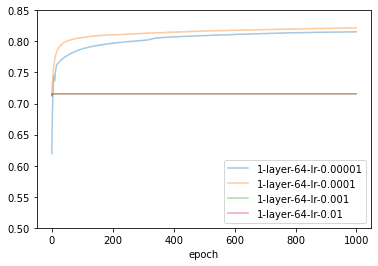

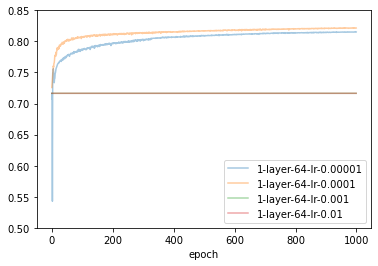

In [8]:
plot_accuracies(hist0, alpha=0.4, lower_ylim=.5, upper_ylim=.85)

## Learnings
While the accuracy is very similar for all learning rates, the learning rate of 0.001 resulted in the lowest train & validation loss, while also having a slightly higher accuracy than the other leaning rates.

Following we plot the accuracy, loss and the confusion matrix for the learningn rate 0.001

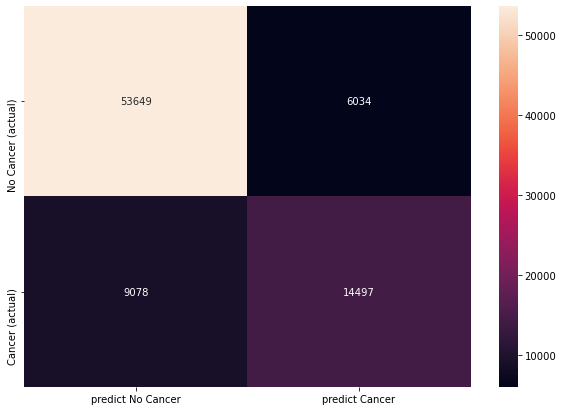

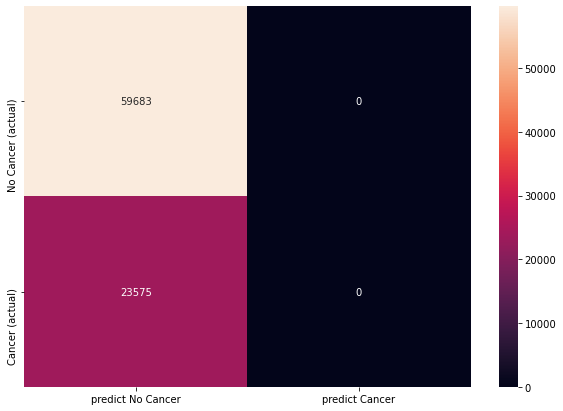

In [9]:
# plot confuction matrix
plt=conf_matrix(model2, x_test, y_test)
plt.show()

# plot confuction matrix
plt=conf_matrix(model3, x_test, y_test)
plt.show()

## Try more hidden nodes and adam optimizer

In [10]:
# lower the number of epochs
epochs = 250

histories = []

name="1-layer-64"
print(name)
model01 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model01.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model01.fit(x_train, y_train, batch_size=batch_size,
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))


name="1-layer-128"
print(name)
model02 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model02.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model02.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-256"
print(name)
model03 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model03.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model03.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-512"
print(name)
model04 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model04.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model04.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-2048"
print(name)
model05 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model05.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model05.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-4096"
print(name)
model06 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model06.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])
histories.append(model06.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))
hist1 = histories

1-layer-64
Epoch 1/250
152/152 - 1s - loss: 28.2731 - accuracy: 0.6727 - val_loss: 11.0484 - val_accuracy: 0.7403
Epoch 2/250
152/152 - 1s - loss: 8.4946 - accuracy: 0.7107 - val_loss: 5.9796 - val_accuracy: 0.7434
Epoch 3/250
152/152 - 1s - loss: 7.3941 - accuracy: 0.7273 - val_loss: 6.2786 - val_accuracy: 0.6923
Epoch 4/250
152/152 - 1s - loss: 8.2238 - accuracy: 0.7199 - val_loss: 5.9158 - val_accuracy: 0.7316
Epoch 5/250
152/152 - 1s - loss: 10.6155 - accuracy: 0.7045 - val_loss: 6.2399 - val_accuracy: 0.7814
Epoch 6/250
152/152 - 1s - loss: 5.2699 - accuracy: 0.7545 - val_loss: 5.1802 - val_accuracy: 0.7677
Epoch 7/250
152/152 - 1s - loss: 6.4024 - accuracy: 0.7230 - val_loss: 12.8591 - val_accuracy: 0.7359
Epoch 8/250
152/152 - 1s - loss: 9.8254 - accuracy: 0.7115 - val_loss: 13.7031 - val_accuracy: 0.7398
Epoch 9/250
152/152 - 1s - loss: 7.0998 - accuracy: 0.7337 - val_loss: 20.5739 - val_accuracy: 0.3359
Epoch 10/250
152/152 - 1s - loss: 6.1794 - accuracy: 0.7383 - val_loss: 4.

Epoch 82/250
152/152 - 1s - loss: 3.6319 - accuracy: 0.7279 - val_loss: 11.6445 - val_accuracy: 0.7190
Epoch 83/250
152/152 - 1s - loss: 3.2304 - accuracy: 0.7402 - val_loss: 2.9570 - val_accuracy: 0.6626
Epoch 84/250
152/152 - 1s - loss: 4.4708 - accuracy: 0.7169 - val_loss: 7.1255 - val_accuracy: 0.4366
Epoch 85/250
152/152 - 1s - loss: 4.0138 - accuracy: 0.7305 - val_loss: 2.3844 - val_accuracy: 0.7924
Epoch 86/250
152/152 - 1s - loss: 2.3789 - accuracy: 0.7573 - val_loss: 2.0618 - val_accuracy: 0.7025
Epoch 87/250
152/152 - 1s - loss: 4.4846 - accuracy: 0.7121 - val_loss: 3.9005 - val_accuracy: 0.7746
Epoch 88/250
152/152 - 1s - loss: 3.4211 - accuracy: 0.7368 - val_loss: 2.3687 - val_accuracy: 0.7941
Epoch 89/250
152/152 - 1s - loss: 3.0034 - accuracy: 0.7438 - val_loss: 5.9078 - val_accuracy: 0.7428
Epoch 90/250
152/152 - 1s - loss: 4.6808 - accuracy: 0.7263 - val_loss: 3.2557 - val_accuracy: 0.6443
Epoch 91/250
152/152 - 1s - loss: 2.8337 - accuracy: 0.7467 - val_loss: 2.2700 - 

Epoch 162/250
152/152 - 1s - loss: 1.7812 - accuracy: 0.7532 - val_loss: 1.0396 - val_accuracy: 0.7870
Epoch 163/250
152/152 - 1s - loss: 2.0631 - accuracy: 0.7432 - val_loss: 1.4557 - val_accuracy: 0.7809
Epoch 164/250
152/152 - 1s - loss: 2.2313 - accuracy: 0.7453 - val_loss: 2.0332 - val_accuracy: 0.7829
Epoch 165/250
152/152 - 1s - loss: 1.6811 - accuracy: 0.7561 - val_loss: 1.1617 - val_accuracy: 0.7853
Epoch 166/250
152/152 - 1s - loss: 2.4140 - accuracy: 0.7305 - val_loss: 1.6418 - val_accuracy: 0.7950
Epoch 167/250
152/152 - 1s - loss: 1.9335 - accuracy: 0.7527 - val_loss: 1.5333 - val_accuracy: 0.7721
Epoch 168/250
152/152 - 1s - loss: 1.6504 - accuracy: 0.7511 - val_loss: 1.0398 - val_accuracy: 0.7878
Epoch 169/250
152/152 - 1s - loss: 2.8188 - accuracy: 0.7176 - val_loss: 1.5178 - val_accuracy: 0.8027
Epoch 170/250
152/152 - 1s - loss: 1.8837 - accuracy: 0.7517 - val_loss: 2.3798 - val_accuracy: 0.7528
Epoch 171/250
152/152 - 1s - loss: 2.0704 - accuracy: 0.7481 - val_loss: 

Epoch 242/250
152/152 - 1s - loss: 1.2020 - accuracy: 0.7513 - val_loss: 1.0084 - val_accuracy: 0.6964
Epoch 243/250
152/152 - 1s - loss: 1.0277 - accuracy: 0.7537 - val_loss: 1.2989 - val_accuracy: 0.6769
Epoch 244/250
152/152 - 1s - loss: 1.3687 - accuracy: 0.7432 - val_loss: 0.6737 - val_accuracy: 0.7879
Epoch 245/250
152/152 - 1s - loss: 0.8982 - accuracy: 0.7629 - val_loss: 0.6746 - val_accuracy: 0.7840
Epoch 246/250
152/152 - 1s - loss: 1.3183 - accuracy: 0.7447 - val_loss: 0.8355 - val_accuracy: 0.7116
Epoch 247/250
152/152 - 1s - loss: 1.0966 - accuracy: 0.7587 - val_loss: 0.6567 - val_accuracy: 0.7893
Epoch 248/250
152/152 - 1s - loss: 1.0531 - accuracy: 0.7522 - val_loss: 1.0025 - val_accuracy: 0.7928
Epoch 249/250
152/152 - 1s - loss: 1.0032 - accuracy: 0.7662 - val_loss: 0.6189 - val_accuracy: 0.7802
Epoch 250/250
152/152 - 1s - loss: 1.6130 - accuracy: 0.7353 - val_loss: 0.6304 - val_accuracy: 0.7860
1-layer-128
Epoch 1/250
152/152 - 1s - loss: 35.0665 - accuracy: 0.6723 -

152/152 - 1s - loss: 3.6272 - accuracy: 0.7284 - val_loss: 1.5460 - val_accuracy: 0.7866
Epoch 73/250
152/152 - 1s - loss: 3.1569 - accuracy: 0.7302 - val_loss: 1.5518 - val_accuracy: 0.7883
Epoch 74/250
152/152 - 1s - loss: 3.4361 - accuracy: 0.7281 - val_loss: 1.9095 - val_accuracy: 0.7965
Epoch 75/250
152/152 - 1s - loss: 3.4612 - accuracy: 0.7335 - val_loss: 2.9023 - val_accuracy: 0.6669
Epoch 76/250
152/152 - 1s - loss: 2.2827 - accuracy: 0.7517 - val_loss: 9.6287 - val_accuracy: 0.3165
Epoch 77/250
152/152 - 1s - loss: 2.6495 - accuracy: 0.7405 - val_loss: 9.9106 - val_accuracy: 0.7163
Epoch 78/250
152/152 - 1s - loss: 4.0143 - accuracy: 0.7118 - val_loss: 1.6856 - val_accuracy: 0.8001
Epoch 79/250
152/152 - 1s - loss: 2.6035 - accuracy: 0.7514 - val_loss: 1.3460 - val_accuracy: 0.7762
Epoch 80/250
152/152 - 1s - loss: 1.7788 - accuracy: 0.7469 - val_loss: 1.3307 - val_accuracy: 0.7842
Epoch 81/250
152/152 - 1s - loss: 4.0374 - accuracy: 0.7067 - val_loss: 3.4365 - val_accuracy: 

Epoch 152/250
152/152 - 1s - loss: 1.5118 - accuracy: 0.7465 - val_loss: 0.9700 - val_accuracy: 0.7272
Epoch 153/250
152/152 - 1s - loss: 1.1762 - accuracy: 0.7558 - val_loss: 0.7951 - val_accuracy: 0.7807
Epoch 154/250
152/152 - 1s - loss: 1.5413 - accuracy: 0.7402 - val_loss: 0.8575 - val_accuracy: 0.7864
Epoch 155/250
152/152 - 1s - loss: 1.6017 - accuracy: 0.7385 - val_loss: 1.0795 - val_accuracy: 0.7955
Epoch 156/250
152/152 - 1s - loss: 1.7965 - accuracy: 0.7311 - val_loss: 1.0959 - val_accuracy: 0.7949
Epoch 157/250
152/152 - 1s - loss: 0.9040 - accuracy: 0.7682 - val_loss: 0.7535 - val_accuracy: 0.7745
Epoch 158/250
152/152 - 1s - loss: 1.1696 - accuracy: 0.7485 - val_loss: 2.3928 - val_accuracy: 0.7267
Epoch 159/250
152/152 - 1s - loss: 1.2780 - accuracy: 0.7563 - val_loss: 0.7354 - val_accuracy: 0.7802
Epoch 160/250
152/152 - 1s - loss: 1.1802 - accuracy: 0.7524 - val_loss: 0.9390 - val_accuracy: 0.7224
Epoch 161/250
152/152 - 1s - loss: 1.3020 - accuracy: 0.7514 - val_loss: 

Epoch 232/250
152/152 - 1s - loss: 0.5812 - accuracy: 0.7735 - val_loss: 1.2420 - val_accuracy: 0.7288
Epoch 233/250
152/152 - 1s - loss: 0.5753 - accuracy: 0.7759 - val_loss: 0.5599 - val_accuracy: 0.7902
Epoch 234/250
152/152 - 1s - loss: 0.4728 - accuracy: 0.7965 - val_loss: 0.6430 - val_accuracy: 0.7143
Epoch 235/250
152/152 - 1s - loss: 0.5242 - accuracy: 0.7873 - val_loss: 0.4812 - val_accuracy: 0.7861
Epoch 236/250
152/152 - 1s - loss: 0.5517 - accuracy: 0.7841 - val_loss: 0.4842 - val_accuracy: 0.7959
Epoch 237/250
152/152 - 1s - loss: 0.4586 - accuracy: 0.7996 - val_loss: 0.4539 - val_accuracy: 0.7990
Epoch 238/250
152/152 - 1s - loss: 0.4635 - accuracy: 0.7992 - val_loss: 0.4458 - val_accuracy: 0.8046
Epoch 239/250
152/152 - 1s - loss: 0.5477 - accuracy: 0.7837 - val_loss: 0.5008 - val_accuracy: 0.7864
Epoch 240/250
152/152 - 1s - loss: 0.4939 - accuracy: 0.7913 - val_loss: 0.4516 - val_accuracy: 0.8001
Epoch 241/250
152/152 - 1s - loss: 0.4580 - accuracy: 0.8008 - val_loss: 

Epoch 62/250
152/152 - 1s - loss: 4.3252 - accuracy: 0.7195 - val_loss: 3.1734 - val_accuracy: 0.7793
Epoch 63/250
152/152 - 1s - loss: 4.5382 - accuracy: 0.7298 - val_loss: 8.3251 - val_accuracy: 0.4120
Epoch 64/250
152/152 - 1s - loss: 5.5425 - accuracy: 0.7065 - val_loss: 3.0345 - val_accuracy: 0.7889
Epoch 65/250
152/152 - 1s - loss: 3.0793 - accuracy: 0.7591 - val_loss: 14.5678 - val_accuracy: 0.7166
Epoch 66/250
152/152 - 1s - loss: 6.2741 - accuracy: 0.6987 - val_loss: 6.4323 - val_accuracy: 0.7521
Epoch 67/250
152/152 - 1s - loss: 4.2533 - accuracy: 0.7458 - val_loss: 2.0165 - val_accuracy: 0.7680
Epoch 68/250
152/152 - 1s - loss: 4.6264 - accuracy: 0.7193 - val_loss: 9.8457 - val_accuracy: 0.7291
Epoch 69/250
152/152 - 1s - loss: 4.5572 - accuracy: 0.7238 - val_loss: 2.8085 - val_accuracy: 0.7848
Epoch 70/250
152/152 - 1s - loss: 3.6841 - accuracy: 0.7346 - val_loss: 9.8962 - val_accuracy: 0.7227
Epoch 71/250
152/152 - 1s - loss: 3.2874 - accuracy: 0.7508 - val_loss: 1.7080 - 

Epoch 142/250
152/152 - 1s - loss: 1.3192 - accuracy: 0.7447 - val_loss: 0.8754 - val_accuracy: 0.7769
Epoch 143/250
152/152 - 1s - loss: 1.0117 - accuracy: 0.7520 - val_loss: 0.8973 - val_accuracy: 0.7929
Epoch 144/250
152/152 - 1s - loss: 1.3138 - accuracy: 0.7412 - val_loss: 1.0314 - val_accuracy: 0.7941
Epoch 145/250
152/152 - 1s - loss: 1.5314 - accuracy: 0.7362 - val_loss: 1.0760 - val_accuracy: 0.7030
Epoch 146/250
152/152 - 1s - loss: 0.8934 - accuracy: 0.7595 - val_loss: 0.7219 - val_accuracy: 0.7731
Epoch 147/250
152/152 - 1s - loss: 1.4480 - accuracy: 0.7291 - val_loss: 1.8410 - val_accuracy: 0.7441
Epoch 148/250
152/152 - 1s - loss: 0.7948 - accuracy: 0.7681 - val_loss: 0.8306 - val_accuracy: 0.7579
Epoch 149/250
152/152 - 1s - loss: 1.2486 - accuracy: 0.7430 - val_loss: 0.6775 - val_accuracy: 0.7638
Epoch 150/250
152/152 - 1s - loss: 1.1440 - accuracy: 0.7427 - val_loss: 1.4606 - val_accuracy: 0.7730
Epoch 151/250
152/152 - 1s - loss: 1.3352 - accuracy: 0.7458 - val_loss: 

Epoch 222/250
152/152 - 1s - loss: 0.4972 - accuracy: 0.7900 - val_loss: 0.6257 - val_accuracy: 0.7743
Epoch 223/250
152/152 - 1s - loss: 0.5437 - accuracy: 0.7829 - val_loss: 0.4603 - val_accuracy: 0.7997
Epoch 224/250
152/152 - 1s - loss: 0.5558 - accuracy: 0.7840 - val_loss: 0.5669 - val_accuracy: 0.7495
Epoch 225/250
152/152 - 1s - loss: 0.6006 - accuracy: 0.7730 - val_loss: 0.4628 - val_accuracy: 0.8014
Epoch 226/250
152/152 - 1s - loss: 0.4558 - accuracy: 0.8027 - val_loss: 0.4786 - val_accuracy: 0.7998
Epoch 227/250
152/152 - 1s - loss: 0.4903 - accuracy: 0.7944 - val_loss: 0.4824 - val_accuracy: 0.7965
Epoch 228/250
152/152 - 1s - loss: 0.5512 - accuracy: 0.7845 - val_loss: 0.5822 - val_accuracy: 0.7859
Epoch 229/250
152/152 - 1s - loss: 0.5337 - accuracy: 0.7845 - val_loss: 0.4706 - val_accuracy: 0.7959
Epoch 230/250
152/152 - 1s - loss: 0.4835 - accuracy: 0.7952 - val_loss: 0.4827 - val_accuracy: 0.8000
Epoch 231/250
152/152 - 1s - loss: 0.4872 - accuracy: 0.7937 - val_loss: 

Epoch 52/250
152/152 - 2s - loss: 3.4819 - accuracy: 0.7521 - val_loss: 2.8810 - val_accuracy: 0.6110
Epoch 53/250
152/152 - 2s - loss: 5.0305 - accuracy: 0.7141 - val_loss: 4.1132 - val_accuracy: 0.6475
Epoch 54/250
152/152 - 2s - loss: 3.7422 - accuracy: 0.7379 - val_loss: 11.1308 - val_accuracy: 0.3355
Epoch 55/250
152/152 - 2s - loss: 4.4856 - accuracy: 0.7229 - val_loss: 5.7344 - val_accuracy: 0.7511
Epoch 56/250
152/152 - 2s - loss: 5.0419 - accuracy: 0.7074 - val_loss: 4.4338 - val_accuracy: 0.7703
Epoch 57/250
152/152 - 2s - loss: 2.6238 - accuracy: 0.7655 - val_loss: 1.6110 - val_accuracy: 0.7883
Epoch 58/250
152/152 - 2s - loss: 3.8365 - accuracy: 0.7215 - val_loss: 3.9638 - val_accuracy: 0.7612
Epoch 59/250
152/152 - 2s - loss: 4.3680 - accuracy: 0.7168 - val_loss: 2.3105 - val_accuracy: 0.7697
Epoch 60/250
152/152 - 2s - loss: 3.7689 - accuracy: 0.7302 - val_loss: 1.8129 - val_accuracy: 0.8016
Epoch 61/250
152/152 - 2s - loss: 4.4259 - accuracy: 0.7129 - val_loss: 2.0605 - 

Epoch 132/250
152/152 - 2s - loss: 0.5291 - accuracy: 0.7915 - val_loss: 0.5024 - val_accuracy: 0.7813
Epoch 133/250
152/152 - 2s - loss: 0.4975 - accuracy: 0.7915 - val_loss: 0.4628 - val_accuracy: 0.8017
Epoch 134/250
152/152 - 2s - loss: 0.4856 - accuracy: 0.7945 - val_loss: 0.4613 - val_accuracy: 0.7987
Epoch 135/250
152/152 - 2s - loss: 0.5208 - accuracy: 0.7826 - val_loss: 0.4499 - val_accuracy: 0.8054
Epoch 136/250
152/152 - 2s - loss: 0.4444 - accuracy: 0.8057 - val_loss: 0.4329 - val_accuracy: 0.8097
Epoch 137/250
152/152 - 2s - loss: 0.4307 - accuracy: 0.8099 - val_loss: 0.4456 - val_accuracy: 0.8036
Epoch 138/250
152/152 - 2s - loss: 0.4422 - accuracy: 0.8064 - val_loss: 0.4357 - val_accuracy: 0.8089
Epoch 139/250
152/152 - 2s - loss: 0.4448 - accuracy: 0.8050 - val_loss: 0.5185 - val_accuracy: 0.7730
Epoch 140/250
152/152 - 2s - loss: 0.4389 - accuracy: 0.8065 - val_loss: 0.4608 - val_accuracy: 0.7956
Epoch 141/250
152/152 - 2s - loss: 0.4664 - accuracy: 0.7977 - val_loss: 

Epoch 212/250
152/152 - 2s - loss: 0.3928 - accuracy: 0.8284 - val_loss: 0.3974 - val_accuracy: 0.8270
Epoch 213/250
152/152 - 2s - loss: 0.3918 - accuracy: 0.8287 - val_loss: 0.4005 - val_accuracy: 0.8261
Epoch 214/250
152/152 - 2s - loss: 0.3908 - accuracy: 0.8288 - val_loss: 0.3955 - val_accuracy: 0.8276
Epoch 215/250
152/152 - 2s - loss: 0.3934 - accuracy: 0.8279 - val_loss: 0.3964 - val_accuracy: 0.8271
Epoch 216/250
152/152 - 2s - loss: 0.3898 - accuracy: 0.8300 - val_loss: 0.3990 - val_accuracy: 0.8257
Epoch 217/250
152/152 - 2s - loss: 0.3925 - accuracy: 0.8281 - val_loss: 0.3966 - val_accuracy: 0.8268
Epoch 218/250
152/152 - 2s - loss: 0.3882 - accuracy: 0.8303 - val_loss: 0.3964 - val_accuracy: 0.8261
Epoch 219/250
152/152 - 2s - loss: 0.3911 - accuracy: 0.8288 - val_loss: 0.4058 - val_accuracy: 0.8225
Epoch 220/250
152/152 - 2s - loss: 0.3889 - accuracy: 0.8299 - val_loss: 0.4022 - val_accuracy: 0.8250
Epoch 221/250
152/152 - 2s - loss: 0.3870 - accuracy: 0.8313 - val_loss: 

Epoch 42/250
152/152 - 2s - loss: 5.7681 - accuracy: 0.7328 - val_loss: 3.3718 - val_accuracy: 0.7742
Epoch 43/250
152/152 - 2s - loss: 5.8546 - accuracy: 0.7349 - val_loss: 2.6473 - val_accuracy: 0.7653
Epoch 44/250
152/152 - 2s - loss: 4.1479 - accuracy: 0.7510 - val_loss: 18.1055 - val_accuracy: 0.2947
Epoch 45/250
152/152 - 2s - loss: 6.1065 - accuracy: 0.7131 - val_loss: 2.2028 - val_accuracy: 0.7967
Epoch 46/250
152/152 - 2s - loss: 5.7624 - accuracy: 0.7153 - val_loss: 2.9459 - val_accuracy: 0.7987
Epoch 47/250
152/152 - 2s - loss: 5.4528 - accuracy: 0.7278 - val_loss: 8.8313 - val_accuracy: 0.7401
Epoch 48/250
152/152 - 2s - loss: 3.6659 - accuracy: 0.7575 - val_loss: 2.1185 - val_accuracy: 0.7957
Epoch 49/250
152/152 - 2s - loss: 5.6230 - accuracy: 0.7024 - val_loss: 2.2819 - val_accuracy: 0.8015
Epoch 50/250
152/152 - 2s - loss: 4.5387 - accuracy: 0.7252 - val_loss: 2.4867 - val_accuracy: 0.7850
Epoch 51/250
152/152 - 2s - loss: 3.1073 - accuracy: 0.7542 - val_loss: 1.9795 - 

152/152 - 2s - loss: 0.4246 - accuracy: 0.8126 - val_loss: 0.4282 - val_accuracy: 0.8114
Epoch 123/250
152/152 - 2s - loss: 0.4145 - accuracy: 0.8167 - val_loss: 0.4305 - val_accuracy: 0.8116
Epoch 124/250
152/152 - 2s - loss: 0.4249 - accuracy: 0.8126 - val_loss: 0.4189 - val_accuracy: 0.8152
Epoch 125/250
152/152 - 2s - loss: 0.5687 - accuracy: 0.7735 - val_loss: 0.4417 - val_accuracy: 0.8062
Epoch 126/250
152/152 - 2s - loss: 0.4240 - accuracy: 0.8121 - val_loss: 0.4219 - val_accuracy: 0.8079
Epoch 127/250
152/152 - 2s - loss: 0.4122 - accuracy: 0.8169 - val_loss: 0.4139 - val_accuracy: 0.8125
Epoch 128/250
152/152 - 2s - loss: 0.4806 - accuracy: 0.7981 - val_loss: 0.4358 - val_accuracy: 0.8055
Epoch 129/250
152/152 - 2s - loss: 0.4455 - accuracy: 0.8048 - val_loss: 0.4200 - val_accuracy: 0.8096
Epoch 130/250
152/152 - 2s - loss: 0.4114 - accuracy: 0.8165 - val_loss: 0.4339 - val_accuracy: 0.8012
Epoch 131/250
152/152 - 2s - loss: 0.4126 - accuracy: 0.8162 - val_loss: 0.4107 - val_a

Epoch 202/250
152/152 - 3s - loss: 0.3900 - accuracy: 0.8293 - val_loss: 0.4074 - val_accuracy: 0.8197
Epoch 203/250
152/152 - 3s - loss: 0.3920 - accuracy: 0.8278 - val_loss: 0.4169 - val_accuracy: 0.8165
Epoch 204/250
152/152 - 3s - loss: 0.3901 - accuracy: 0.8287 - val_loss: 0.3970 - val_accuracy: 0.8255
Epoch 205/250
152/152 - 3s - loss: 0.3882 - accuracy: 0.8299 - val_loss: 0.3997 - val_accuracy: 0.8236
Epoch 206/250
152/152 - 3s - loss: 0.3880 - accuracy: 0.8301 - val_loss: 0.3958 - val_accuracy: 0.8253
Epoch 207/250
152/152 - 3s - loss: 0.3880 - accuracy: 0.8301 - val_loss: 0.3959 - val_accuracy: 0.8264
Epoch 208/250
152/152 - 3s - loss: 0.3896 - accuracy: 0.8294 - val_loss: 0.3935 - val_accuracy: 0.8268
Epoch 209/250
152/152 - 3s - loss: 0.3878 - accuracy: 0.8301 - val_loss: 0.3949 - val_accuracy: 0.8246
Epoch 210/250
152/152 - 3s - loss: 0.3890 - accuracy: 0.8299 - val_loss: 0.4044 - val_accuracy: 0.8224
Epoch 211/250
152/152 - 3s - loss: 0.3905 - accuracy: 0.8292 - val_loss: 

Epoch 32/250
152/152 - 4s - loss: 6.4989 - accuracy: 0.7243 - val_loss: 6.0455 - val_accuracy: 0.7669
Epoch 33/250
152/152 - 4s - loss: 5.3993 - accuracy: 0.7423 - val_loss: 2.2507 - val_accuracy: 0.8125
Epoch 34/250
152/152 - 4s - loss: 5.0157 - accuracy: 0.7382 - val_loss: 2.9536 - val_accuracy: 0.7891
Epoch 35/250
152/152 - 4s - loss: 6.4491 - accuracy: 0.7162 - val_loss: 2.2923 - val_accuracy: 0.8103
Epoch 36/250
152/152 - 4s - loss: 4.5232 - accuracy: 0.7351 - val_loss: 12.6687 - val_accuracy: 0.7200
Epoch 37/250
152/152 - 4s - loss: 4.5917 - accuracy: 0.7351 - val_loss: 2.0828 - val_accuracy: 0.7603
Epoch 38/250
152/152 - 4s - loss: 5.4191 - accuracy: 0.7163 - val_loss: 2.0011 - val_accuracy: 0.7976
Epoch 39/250
152/152 - 4s - loss: 3.8988 - accuracy: 0.7354 - val_loss: 2.0053 - val_accuracy: 0.7757
Epoch 40/250
152/152 - 4s - loss: 3.7601 - accuracy: 0.7375 - val_loss: 1.4255 - val_accuracy: 0.8011
Epoch 41/250
152/152 - 4s - loss: 4.2475 - accuracy: 0.7389 - val_loss: 1.3244 - 

Epoch 113/250
152/152 - 4s - loss: 0.4061 - accuracy: 0.8213 - val_loss: 0.4011 - val_accuracy: 0.8242
Epoch 114/250
152/152 - 4s - loss: 0.4020 - accuracy: 0.8235 - val_loss: 0.4126 - val_accuracy: 0.8164
Epoch 115/250
152/152 - 4s - loss: 0.4013 - accuracy: 0.8233 - val_loss: 0.3994 - val_accuracy: 0.8242
Epoch 116/250
152/152 - 4s - loss: 0.4040 - accuracy: 0.8225 - val_loss: 0.4061 - val_accuracy: 0.8207
Epoch 117/250
152/152 - 4s - loss: 0.4003 - accuracy: 0.8242 - val_loss: 0.4138 - val_accuracy: 0.8166
Epoch 118/250
152/152 - 4s - loss: 0.4079 - accuracy: 0.8211 - val_loss: 0.4069 - val_accuracy: 0.8203
Epoch 119/250
152/152 - 4s - loss: 0.4056 - accuracy: 0.8219 - val_loss: 0.4118 - val_accuracy: 0.8204
Epoch 120/250
152/152 - 4s - loss: 0.4013 - accuracy: 0.8233 - val_loss: 0.3986 - val_accuracy: 0.8250
Epoch 121/250
152/152 - 4s - loss: 0.4026 - accuracy: 0.8233 - val_loss: 0.3970 - val_accuracy: 0.8273
Epoch 122/250
152/152 - 4s - loss: 0.3970 - accuracy: 0.8256 - val_loss: 

Epoch 193/250
152/152 - 4s - loss: 0.3883 - accuracy: 0.8289 - val_loss: 0.3997 - val_accuracy: 0.8226
Epoch 194/250
152/152 - 4s - loss: 0.3882 - accuracy: 0.8293 - val_loss: 0.4044 - val_accuracy: 0.8201
Epoch 195/250
152/152 - 3s - loss: 0.3890 - accuracy: 0.8283 - val_loss: 0.3981 - val_accuracy: 0.8244
Epoch 196/250
152/152 - 3s - loss: 0.3933 - accuracy: 0.8267 - val_loss: 0.3961 - val_accuracy: 0.8250
Epoch 197/250
152/152 - 3s - loss: 0.3887 - accuracy: 0.8285 - val_loss: 0.4006 - val_accuracy: 0.8213
Epoch 198/250
152/152 - 3s - loss: 0.3884 - accuracy: 0.8289 - val_loss: 0.3975 - val_accuracy: 0.8245
Epoch 199/250
152/152 - 3s - loss: 0.3872 - accuracy: 0.8297 - val_loss: 0.4000 - val_accuracy: 0.8221
Epoch 200/250
152/152 - 3s - loss: 0.3889 - accuracy: 0.8284 - val_loss: 0.3981 - val_accuracy: 0.8241
Epoch 201/250
152/152 - 3s - loss: 0.3872 - accuracy: 0.8294 - val_loss: 0.3983 - val_accuracy: 0.8233
Epoch 202/250
152/152 - 3s - loss: 0.3946 - accuracy: 0.8261 - val_loss: 

In [11]:
acc_df(histories)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-64,2.97,72.41%,1.28,80.34%
1-layer-128,0.46,80.06%,0.44,80.86%
1-layer-256,0.43,81.07%,0.46,81.11%
1-layer-512,0.39,82.83%,0.40,82.82%
1-layer-2048,0.38,83.30%,0.39,82.84%
1-layer-4096,0.40,82.33%,0.40,82.73%


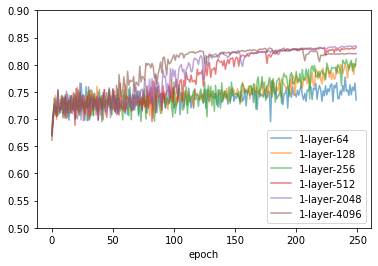

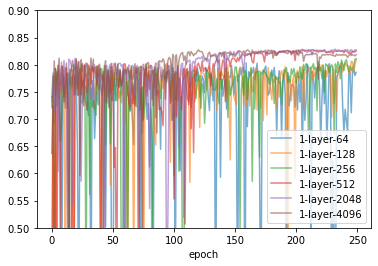

In [12]:
plot_accuracies(hist1, lower_ylim=.5, upper_ylim=.9)

In [13]:
# lower the number of epochs
epochs = 250

histories = []

name="1-layer-64"
print(name)
model001 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model001.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model001.fit(x_train, y_train, batch_size=batch_size,
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))


name="1-layer-128"
print(name)
model002 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model002.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model002.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-256"
print(name)
model003 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model003.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model003.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-512"
print(name)
model004 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model004.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model004.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-2048"
print(name)
model005 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model005.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model005.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))

name="1-layer-4096"
print(name)
model006 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model006.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])
histories.append(model06.fit(x_train, y_train, batch_size=batch_size, 
                                   epochs=epochs, validation_data=(x_val,y_val),
                                   verbose=2))
hist1_2 = histories

1-layer-64
Epoch 1/250
152/152 - 1s - loss: 174.0329 - accuracy: 0.6554 - val_loss: 16.5054 - val_accuracy: 0.7663
Epoch 2/250
152/152 - 1s - loss: 23.6682 - accuracy: 0.7336 - val_loss: 7.4681 - val_accuracy: 0.8028
Epoch 3/250
152/152 - 1s - loss: 22.6224 - accuracy: 0.7187 - val_loss: 7.8177 - val_accuracy: 0.7824
Epoch 4/250
152/152 - 1s - loss: 25.9770 - accuracy: 0.7072 - val_loss: 9.3033 - val_accuracy: 0.8020
Epoch 5/250
152/152 - 1s - loss: 26.0642 - accuracy: 0.7224 - val_loss: 14.7105 - val_accuracy: 0.7215
Epoch 6/250
152/152 - 1s - loss: 17.6284 - accuracy: 0.7393 - val_loss: 7.0451 - val_accuracy: 0.8080
Epoch 7/250
152/152 - 1s - loss: 17.5364 - accuracy: 0.7288 - val_loss: 6.2575 - val_accuracy: 0.8049
Epoch 8/250
152/152 - 1s - loss: 18.6143 - accuracy: 0.7243 - val_loss: 6.6747 - val_accuracy: 0.7680
Epoch 9/250
152/152 - 1s - loss: 16.5995 - accuracy: 0.7229 - val_loss: 52.5354 - val_accuracy: 0.2900
Epoch 10/250
152/152 - 1s - loss: 16.2563 - accuracy: 0.7231 - val_

152/152 - 1s - loss: 0.4004 - accuracy: 0.8237 - val_loss: 0.3961 - val_accuracy: 0.8263
Epoch 82/250
152/152 - 1s - loss: 0.4022 - accuracy: 0.8236 - val_loss: 0.4062 - val_accuracy: 0.8159
Epoch 83/250
152/152 - 1s - loss: 0.4037 - accuracy: 0.8232 - val_loss: 0.5357 - val_accuracy: 0.7500
Epoch 84/250
152/152 - 1s - loss: 0.4059 - accuracy: 0.8223 - val_loss: 0.4235 - val_accuracy: 0.8153
Epoch 85/250
152/152 - 1s - loss: 0.3994 - accuracy: 0.8236 - val_loss: 0.3961 - val_accuracy: 0.8267
Epoch 86/250
152/152 - 1s - loss: 0.4123 - accuracy: 0.8199 - val_loss: 0.3981 - val_accuracy: 0.8258
Epoch 87/250
152/152 - 1s - loss: 0.4062 - accuracy: 0.8222 - val_loss: 0.4010 - val_accuracy: 0.8250
Epoch 88/250
152/152 - 1s - loss: 0.4036 - accuracy: 0.8223 - val_loss: 0.4090 - val_accuracy: 0.8244
Epoch 89/250
152/152 - 1s - loss: 0.4145 - accuracy: 0.8196 - val_loss: 0.4054 - val_accuracy: 0.8248
Epoch 90/250
152/152 - 1s - loss: 0.4017 - accuracy: 0.8244 - val_loss: 0.4079 - val_accuracy: 

Epoch 161/250
152/152 - 1s - loss: 0.4030 - accuracy: 0.8224 - val_loss: 0.3993 - val_accuracy: 0.8256
Epoch 162/250
152/152 - 1s - loss: 0.4014 - accuracy: 0.8227 - val_loss: 0.4018 - val_accuracy: 0.8195
Epoch 163/250
152/152 - 1s - loss: 0.3975 - accuracy: 0.8245 - val_loss: 0.3996 - val_accuracy: 0.8230
Epoch 164/250
152/152 - 1s - loss: 0.3998 - accuracy: 0.8242 - val_loss: 0.4029 - val_accuracy: 0.8208
Epoch 165/250
152/152 - 1s - loss: 0.3973 - accuracy: 0.8246 - val_loss: 0.4010 - val_accuracy: 0.8254
Epoch 166/250
152/152 - 1s - loss: 0.4036 - accuracy: 0.8224 - val_loss: 0.3988 - val_accuracy: 0.8225
Epoch 167/250
152/152 - 1s - loss: 0.4003 - accuracy: 0.8237 - val_loss: 0.3995 - val_accuracy: 0.8222
Epoch 168/250
152/152 - 1s - loss: 0.4011 - accuracy: 0.8231 - val_loss: 0.3997 - val_accuracy: 0.8236
Epoch 169/250
152/152 - 1s - loss: 0.3985 - accuracy: 0.8238 - val_loss: 0.4001 - val_accuracy: 0.8228
Epoch 170/250
152/152 - 1s - loss: 0.3989 - accuracy: 0.8240 - val_loss: 

Epoch 241/250
152/152 - 1s - loss: 0.3928 - accuracy: 0.8284 - val_loss: 0.4099 - val_accuracy: 0.8171
Epoch 242/250
152/152 - 1s - loss: 0.3969 - accuracy: 0.8264 - val_loss: 0.4029 - val_accuracy: 0.8195
Epoch 243/250
152/152 - 1s - loss: 0.3889 - accuracy: 0.8290 - val_loss: 0.4083 - val_accuracy: 0.8208
Epoch 244/250
152/152 - 1s - loss: 0.3960 - accuracy: 0.8270 - val_loss: 0.4199 - val_accuracy: 0.8170
Epoch 245/250
152/152 - 1s - loss: 0.3920 - accuracy: 0.8281 - val_loss: 0.4044 - val_accuracy: 0.8186
Epoch 246/250
152/152 - 1s - loss: 0.3943 - accuracy: 0.8274 - val_loss: 0.4230 - val_accuracy: 0.8201
Epoch 247/250
152/152 - 1s - loss: 0.3949 - accuracy: 0.8269 - val_loss: 0.4010 - val_accuracy: 0.8247
Epoch 248/250
152/152 - 1s - loss: 0.3892 - accuracy: 0.8287 - val_loss: 0.4017 - val_accuracy: 0.8217
Epoch 249/250
152/152 - 1s - loss: 0.3887 - accuracy: 0.8295 - val_loss: 0.4017 - val_accuracy: 0.8231
Epoch 250/250
152/152 - 1s - loss: 0.3946 - accuracy: 0.8276 - val_loss: 

Epoch 72/250
152/152 - 1s - loss: 0.4076 - accuracy: 0.8173 - val_loss: 0.4029 - val_accuracy: 0.8191
Epoch 73/250
152/152 - 1s - loss: 0.4146 - accuracy: 0.8153 - val_loss: 0.4072 - val_accuracy: 0.8168
Epoch 74/250
152/152 - 1s - loss: 0.4098 - accuracy: 0.8165 - val_loss: 0.4025 - val_accuracy: 0.8177
Epoch 75/250
152/152 - 1s - loss: 0.4097 - accuracy: 0.8171 - val_loss: 0.4051 - val_accuracy: 0.8136
Epoch 76/250
152/152 - 1s - loss: 0.4100 - accuracy: 0.8161 - val_loss: 0.4033 - val_accuracy: 0.8172
Epoch 77/250
152/152 - 1s - loss: 0.4137 - accuracy: 0.8160 - val_loss: 0.4056 - val_accuracy: 0.8162
Epoch 78/250
152/152 - 1s - loss: 0.4105 - accuracy: 0.8162 - val_loss: 0.4020 - val_accuracy: 0.8193
Epoch 79/250
152/152 - 1s - loss: 0.4071 - accuracy: 0.8182 - val_loss: 0.4013 - val_accuracy: 0.8183
Epoch 80/250
152/152 - 1s - loss: 0.4121 - accuracy: 0.8167 - val_loss: 0.4018 - val_accuracy: 0.8181
Epoch 81/250
152/152 - 1s - loss: 0.4134 - accuracy: 0.8157 - val_loss: 0.4047 - v

Epoch 152/250
152/152 - 1s - loss: 0.4076 - accuracy: 0.8202 - val_loss: 0.4027 - val_accuracy: 0.8197
Epoch 153/250
152/152 - 1s - loss: 0.4040 - accuracy: 0.8208 - val_loss: 0.4388 - val_accuracy: 0.8043
Epoch 154/250
152/152 - 1s - loss: 0.4013 - accuracy: 0.8214 - val_loss: 0.4251 - val_accuracy: 0.8097
Epoch 155/250
152/152 - 1s - loss: 0.4059 - accuracy: 0.8200 - val_loss: 0.4065 - val_accuracy: 0.8170
Epoch 156/250
152/152 - 1s - loss: 0.4030 - accuracy: 0.8207 - val_loss: 0.4027 - val_accuracy: 0.8183
Epoch 157/250
152/152 - 1s - loss: 0.4013 - accuracy: 0.8217 - val_loss: 0.4057 - val_accuracy: 0.8190
Epoch 158/250
152/152 - 1s - loss: 0.4053 - accuracy: 0.8198 - val_loss: 0.4116 - val_accuracy: 0.8161
Epoch 159/250
152/152 - 1s - loss: 0.4037 - accuracy: 0.8210 - val_loss: 0.4086 - val_accuracy: 0.8136
Epoch 160/250
152/152 - 1s - loss: 0.4007 - accuracy: 0.8218 - val_loss: 0.4096 - val_accuracy: 0.8187
Epoch 161/250
152/152 - 1s - loss: 0.4010 - accuracy: 0.8219 - val_loss: 

Epoch 232/250
152/152 - 1s - loss: 0.3980 - accuracy: 0.8246 - val_loss: 0.4106 - val_accuracy: 0.8164
Epoch 233/250
152/152 - 1s - loss: 0.3982 - accuracy: 0.8244 - val_loss: 0.4239 - val_accuracy: 0.8099
Epoch 234/250
152/152 - 1s - loss: 0.3966 - accuracy: 0.8243 - val_loss: 0.4090 - val_accuracy: 0.8152
Epoch 235/250
152/152 - 1s - loss: 0.4014 - accuracy: 0.8227 - val_loss: 0.4045 - val_accuracy: 0.8185
Epoch 236/250
152/152 - 1s - loss: 0.4025 - accuracy: 0.8227 - val_loss: 0.4352 - val_accuracy: 0.8160
Epoch 237/250
152/152 - 1s - loss: 0.3979 - accuracy: 0.8240 - val_loss: 0.4082 - val_accuracy: 0.8173
Epoch 238/250
152/152 - 1s - loss: 0.3966 - accuracy: 0.8244 - val_loss: 0.4074 - val_accuracy: 0.8187
Epoch 239/250
152/152 - 1s - loss: 0.3970 - accuracy: 0.8249 - val_loss: 0.4070 - val_accuracy: 0.8150
Epoch 240/250
152/152 - 1s - loss: 0.3976 - accuracy: 0.8234 - val_loss: 0.4058 - val_accuracy: 0.8197
Epoch 241/250
152/152 - 1s - loss: 0.3984 - accuracy: 0.8235 - val_loss: 

Epoch 62/250
152/152 - 1s - loss: 0.4051 - accuracy: 0.8240 - val_loss: 0.4186 - val_accuracy: 0.8237
Epoch 63/250
152/152 - 1s - loss: 0.4071 - accuracy: 0.8225 - val_loss: 0.3970 - val_accuracy: 0.8240
Epoch 64/250
152/152 - 1s - loss: 0.4014 - accuracy: 0.8252 - val_loss: 0.4351 - val_accuracy: 0.8154
Epoch 65/250
152/152 - 1s - loss: 0.4026 - accuracy: 0.8240 - val_loss: 0.4639 - val_accuracy: 0.8063
Epoch 66/250
152/152 - 1s - loss: 0.4037 - accuracy: 0.8245 - val_loss: 0.4499 - val_accuracy: 0.8009
Epoch 67/250
152/152 - 1s - loss: 0.4182 - accuracy: 0.8177 - val_loss: 0.4044 - val_accuracy: 0.8243
Epoch 68/250
152/152 - 1s - loss: 0.4049 - accuracy: 0.8246 - val_loss: 0.4148 - val_accuracy: 0.8194
Epoch 69/250
152/152 - 1s - loss: 0.4076 - accuracy: 0.8228 - val_loss: 0.4580 - val_accuracy: 0.8110
Epoch 70/250
152/152 - 1s - loss: 0.9794 - accuracy: 0.8190 - val_loss: 0.8288 - val_accuracy: 0.4156
Epoch 71/250
152/152 - 1s - loss: 0.4352 - accuracy: 0.8053 - val_loss: 0.4011 - v

Epoch 142/250
152/152 - 1s - loss: 0.3968 - accuracy: 0.8250 - val_loss: 0.3996 - val_accuracy: 0.8227
Epoch 143/250
152/152 - 1s - loss: 0.3979 - accuracy: 0.8248 - val_loss: 0.4013 - val_accuracy: 0.8218
Epoch 144/250
152/152 - 1s - loss: 0.3971 - accuracy: 0.8244 - val_loss: 0.4285 - val_accuracy: 0.8112
Epoch 145/250
152/152 - 1s - loss: 0.3995 - accuracy: 0.8243 - val_loss: 0.4042 - val_accuracy: 0.8213
Epoch 146/250
152/152 - 1s - loss: 0.3991 - accuracy: 0.8241 - val_loss: 0.3989 - val_accuracy: 0.8237
Epoch 147/250
152/152 - 1s - loss: 0.3993 - accuracy: 0.8237 - val_loss: 0.4123 - val_accuracy: 0.8206
Epoch 148/250
152/152 - 1s - loss: 0.3994 - accuracy: 0.8240 - val_loss: 0.4221 - val_accuracy: 0.8159
Epoch 149/250
152/152 - 1s - loss: 0.4096 - accuracy: 0.8209 - val_loss: 0.3986 - val_accuracy: 0.8234
Epoch 150/250
152/152 - 1s - loss: 0.3997 - accuracy: 0.8238 - val_loss: 0.4050 - val_accuracy: 0.8219
Epoch 151/250
152/152 - 1s - loss: 0.3976 - accuracy: 0.8257 - val_loss: 

Epoch 222/250
152/152 - 1s - loss: 0.3935 - accuracy: 0.8280 - val_loss: 0.4015 - val_accuracy: 0.8225
Epoch 223/250
152/152 - 1s - loss: 0.3922 - accuracy: 0.8278 - val_loss: 0.4231 - val_accuracy: 0.8158
Epoch 224/250
152/152 - 1s - loss: 0.3955 - accuracy: 0.8260 - val_loss: 0.4036 - val_accuracy: 0.8197
Epoch 225/250
152/152 - 1s - loss: 0.3897 - accuracy: 0.8290 - val_loss: 0.4112 - val_accuracy: 0.8191
Epoch 226/250
152/152 - 1s - loss: 0.3914 - accuracy: 0.8284 - val_loss: 0.4047 - val_accuracy: 0.8214
Epoch 227/250
152/152 - 1s - loss: 0.3916 - accuracy: 0.8282 - val_loss: 0.4049 - val_accuracy: 0.8192
Epoch 228/250
152/152 - 1s - loss: 0.3899 - accuracy: 0.8287 - val_loss: 0.4001 - val_accuracy: 0.8220
Epoch 229/250
152/152 - 1s - loss: 0.3930 - accuracy: 0.8273 - val_loss: 0.4080 - val_accuracy: 0.8187
Epoch 230/250
152/152 - 1s - loss: 0.3901 - accuracy: 0.8286 - val_loss: 0.4077 - val_accuracy: 0.8217
Epoch 231/250
152/152 - 1s - loss: 0.3982 - accuracy: 0.8257 - val_loss: 

Epoch 52/250
152/152 - 1s - loss: 0.4405 - accuracy: 0.8031 - val_loss: 0.4349 - val_accuracy: 0.8130
Epoch 53/250
152/152 - 1s - loss: 0.4079 - accuracy: 0.8192 - val_loss: 0.4062 - val_accuracy: 0.8194
Epoch 54/250
152/152 - 1s - loss: 0.4102 - accuracy: 0.8187 - val_loss: 0.4134 - val_accuracy: 0.8157
Epoch 55/250
152/152 - 1s - loss: 0.4081 - accuracy: 0.8196 - val_loss: 0.4005 - val_accuracy: 0.8219
Epoch 56/250
152/152 - 1s - loss: 0.4094 - accuracy: 0.8198 - val_loss: 0.4059 - val_accuracy: 0.8215
Epoch 57/250
152/152 - 1s - loss: 0.4103 - accuracy: 0.8190 - val_loss: 0.4424 - val_accuracy: 0.8081
Epoch 58/250
152/152 - 1s - loss: 0.4128 - accuracy: 0.8183 - val_loss: 0.3999 - val_accuracy: 0.8224
Epoch 59/250
152/152 - 1s - loss: 0.4059 - accuracy: 0.8211 - val_loss: 0.4042 - val_accuracy: 0.8193
Epoch 60/250
152/152 - 1s - loss: 0.4080 - accuracy: 0.8200 - val_loss: 0.4039 - val_accuracy: 0.8218
Epoch 61/250
152/152 - 1s - loss: 0.4085 - accuracy: 0.8204 - val_loss: 0.3982 - v

152/152 - 1s - loss: 0.4017 - accuracy: 0.8227 - val_loss: 0.4179 - val_accuracy: 0.8153
Epoch 133/250
152/152 - 1s - loss: 0.4001 - accuracy: 0.8232 - val_loss: 0.3983 - val_accuracy: 0.8228
Epoch 134/250
152/152 - 1s - loss: 0.4021 - accuracy: 0.8225 - val_loss: 0.4237 - val_accuracy: 0.8157
Epoch 135/250
152/152 - 1s - loss: 0.4073 - accuracy: 0.8206 - val_loss: 0.3984 - val_accuracy: 0.8223
Epoch 136/250
152/152 - 1s - loss: 0.4012 - accuracy: 0.8232 - val_loss: 0.3993 - val_accuracy: 0.8223
Epoch 137/250
152/152 - 1s - loss: 0.4001 - accuracy: 0.8232 - val_loss: 0.4011 - val_accuracy: 0.8220
Epoch 138/250
152/152 - 1s - loss: 0.4016 - accuracy: 0.8230 - val_loss: 0.3983 - val_accuracy: 0.8231
Epoch 139/250
152/152 - 1s - loss: 0.4012 - accuracy: 0.8228 - val_loss: 0.4029 - val_accuracy: 0.8230
Epoch 140/250
152/152 - 1s - loss: 0.4017 - accuracy: 0.8235 - val_loss: 0.4248 - val_accuracy: 0.8125
Epoch 141/250
152/152 - 1s - loss: 0.4011 - accuracy: 0.8238 - val_loss: 0.4026 - val_a

Epoch 212/250
152/152 - 1s - loss: 0.4003 - accuracy: 0.8223 - val_loss: 0.4089 - val_accuracy: 0.8127
Epoch 213/250
152/152 - 2s - loss: 0.4077 - accuracy: 0.8202 - val_loss: 0.4372 - val_accuracy: 0.8101
Epoch 214/250
152/152 - 1s - loss: 0.4054 - accuracy: 0.8204 - val_loss: 0.4033 - val_accuracy: 0.8195
Epoch 215/250
152/152 - 1s - loss: 0.3991 - accuracy: 0.8233 - val_loss: 0.4045 - val_accuracy: 0.8171
Epoch 216/250
152/152 - 1s - loss: 0.3992 - accuracy: 0.8235 - val_loss: 0.4143 - val_accuracy: 0.8134
Epoch 217/250
152/152 - 2s - loss: 0.3969 - accuracy: 0.8238 - val_loss: 0.4087 - val_accuracy: 0.8204
Epoch 218/250
152/152 - 1s - loss: 0.4002 - accuracy: 0.8221 - val_loss: 0.4032 - val_accuracy: 0.8175
Epoch 219/250
152/152 - 2s - loss: 0.3993 - accuracy: 0.8226 - val_loss: 0.4117 - val_accuracy: 0.8180
Epoch 220/250
152/152 - 1s - loss: 0.4026 - accuracy: 0.8220 - val_loss: 0.4053 - val_accuracy: 0.8204
Epoch 221/250
152/152 - 2s - loss: 0.3979 - accuracy: 0.8229 - val_loss: 

Epoch 42/250
152/152 - 2s - loss: 0.4019 - accuracy: 0.8235 - val_loss: 0.4266 - val_accuracy: 0.8155
Epoch 43/250
152/152 - 2s - loss: 0.4108 - accuracy: 0.8202 - val_loss: 0.3957 - val_accuracy: 0.8252
Epoch 44/250
152/152 - 2s - loss: 0.4010 - accuracy: 0.8245 - val_loss: 0.4074 - val_accuracy: 0.8196
Epoch 45/250
152/152 - 2s - loss: 0.4044 - accuracy: 0.8222 - val_loss: 0.4536 - val_accuracy: 0.7999
Epoch 46/250
152/152 - 2s - loss: 0.4089 - accuracy: 0.8214 - val_loss: 0.3941 - val_accuracy: 0.8267
Epoch 47/250
152/152 - 2s - loss: 0.4057 - accuracy: 0.8223 - val_loss: 0.4031 - val_accuracy: 0.8238
Epoch 48/250
152/152 - 2s - loss: 0.4023 - accuracy: 0.8240 - val_loss: 0.4016 - val_accuracy: 0.8252
Epoch 49/250
152/152 - 2s - loss: 0.4074 - accuracy: 0.8227 - val_loss: 0.4232 - val_accuracy: 0.8131
Epoch 50/250
152/152 - 2s - loss: 0.4114 - accuracy: 0.8205 - val_loss: 0.4013 - val_accuracy: 0.8234
Epoch 51/250
152/152 - 2s - loss: 0.4020 - accuracy: 0.8236 - val_loss: 0.4036 - v

152/152 - 2s - loss: 0.4182 - accuracy: 0.8114 - val_loss: 0.4155 - val_accuracy: 0.8093
Epoch 123/250
152/152 - 2s - loss: 0.4173 - accuracy: 0.8117 - val_loss: 0.4238 - val_accuracy: 0.8090
Epoch 124/250
152/152 - 2s - loss: 0.4187 - accuracy: 0.8113 - val_loss: 0.4148 - val_accuracy: 0.8113
Epoch 125/250
152/152 - 2s - loss: 0.4174 - accuracy: 0.8119 - val_loss: 0.4139 - val_accuracy: 0.8110
Epoch 126/250
152/152 - 2s - loss: 0.4178 - accuracy: 0.8112 - val_loss: 0.4141 - val_accuracy: 0.8105
Epoch 127/250
152/152 - 2s - loss: 0.4168 - accuracy: 0.8119 - val_loss: 0.4224 - val_accuracy: 0.8094
Epoch 128/250
152/152 - 2s - loss: 0.4165 - accuracy: 0.8121 - val_loss: 0.4143 - val_accuracy: 0.8102
Epoch 129/250
152/152 - 2s - loss: 0.4170 - accuracy: 0.8115 - val_loss: 0.4232 - val_accuracy: 0.8103
Epoch 130/250
152/152 - 2s - loss: 0.4179 - accuracy: 0.8116 - val_loss: 0.4142 - val_accuracy: 0.8090
Epoch 131/250
152/152 - 2s - loss: 0.4192 - accuracy: 0.8112 - val_loss: 0.4232 - val_a

Epoch 202/250
152/152 - 2s - loss: 0.4122 - accuracy: 0.8137 - val_loss: 0.4170 - val_accuracy: 0.8096
Epoch 203/250
152/152 - 2s - loss: 0.4131 - accuracy: 0.8139 - val_loss: 0.4171 - val_accuracy: 0.8103
Epoch 204/250
152/152 - 2s - loss: 0.4148 - accuracy: 0.8130 - val_loss: 0.4167 - val_accuracy: 0.8085
Epoch 205/250
152/152 - 2s - loss: 0.4144 - accuracy: 0.8135 - val_loss: 0.4190 - val_accuracy: 0.8094
Epoch 206/250
152/152 - 2s - loss: 0.4142 - accuracy: 0.8131 - val_loss: 0.4191 - val_accuracy: 0.8092
Epoch 207/250
152/152 - 2s - loss: 0.4169 - accuracy: 0.8121 - val_loss: 0.4164 - val_accuracy: 0.8093
Epoch 208/250
152/152 - 2s - loss: 0.4146 - accuracy: 0.8136 - val_loss: 0.4154 - val_accuracy: 0.8094
Epoch 209/250
152/152 - 2s - loss: 0.4129 - accuracy: 0.8138 - val_loss: 0.4153 - val_accuracy: 0.8094
Epoch 210/250
152/152 - 2s - loss: 0.4139 - accuracy: 0.8136 - val_loss: 0.4207 - val_accuracy: 0.8093
Epoch 211/250
152/152 - 2s - loss: 0.4126 - accuracy: 0.8141 - val_loss: 

Epoch 32/250
152/152 - 4s - loss: 0.3984 - accuracy: 0.8219 - val_loss: 0.4024 - val_accuracy: 0.8177
Epoch 33/250
152/152 - 4s - loss: 0.3975 - accuracy: 0.8215 - val_loss: 0.4054 - val_accuracy: 0.8187
Epoch 34/250
152/152 - 4s - loss: 0.3971 - accuracy: 0.8219 - val_loss: 0.4172 - val_accuracy: 0.8125
Epoch 35/250
152/152 - 4s - loss: 0.3984 - accuracy: 0.8220 - val_loss: 0.4022 - val_accuracy: 0.8195
Epoch 36/250
152/152 - 4s - loss: 0.3973 - accuracy: 0.8216 - val_loss: 0.4022 - val_accuracy: 0.8187
Epoch 37/250
152/152 - 4s - loss: 0.3984 - accuracy: 0.8217 - val_loss: 0.4025 - val_accuracy: 0.8196
Epoch 38/250
152/152 - 4s - loss: 0.3972 - accuracy: 0.8218 - val_loss: 0.4023 - val_accuracy: 0.8195
Epoch 39/250
152/152 - 4s - loss: 0.3975 - accuracy: 0.8218 - val_loss: 0.4059 - val_accuracy: 0.8168
Epoch 40/250
152/152 - 4s - loss: 0.3977 - accuracy: 0.8223 - val_loss: 0.4023 - val_accuracy: 0.8192
Epoch 41/250
152/152 - 4s - loss: 0.3965 - accuracy: 0.8225 - val_loss: 0.4073 - v

Epoch 113/250
152/152 - 4s - loss: 0.3937 - accuracy: 0.8245 - val_loss: 0.4043 - val_accuracy: 0.8180
Epoch 114/250
152/152 - 4s - loss: 0.3928 - accuracy: 0.8246 - val_loss: 0.4069 - val_accuracy: 0.8170
Epoch 115/250
152/152 - 4s - loss: 0.3926 - accuracy: 0.8249 - val_loss: 0.4047 - val_accuracy: 0.8187
Epoch 116/250
152/152 - 4s - loss: 0.3930 - accuracy: 0.8247 - val_loss: 0.4050 - val_accuracy: 0.8188
Epoch 117/250
152/152 - 4s - loss: 0.3922 - accuracy: 0.8248 - val_loss: 0.4062 - val_accuracy: 0.8171
Epoch 118/250
152/152 - 4s - loss: 0.3941 - accuracy: 0.8240 - val_loss: 0.4035 - val_accuracy: 0.8181
Epoch 119/250
152/152 - 4s - loss: 0.3933 - accuracy: 0.8242 - val_loss: 0.4074 - val_accuracy: 0.8163
Epoch 120/250
152/152 - 4s - loss: 0.3949 - accuracy: 0.8234 - val_loss: 0.4033 - val_accuracy: 0.8182
Epoch 121/250
152/152 - 4s - loss: 0.3926 - accuracy: 0.8247 - val_loss: 0.4093 - val_accuracy: 0.8141
Epoch 122/250
152/152 - 4s - loss: 0.3935 - accuracy: 0.8244 - val_loss: 

Epoch 193/250
152/152 - 4s - loss: 0.3895 - accuracy: 0.8261 - val_loss: 0.4052 - val_accuracy: 0.8179
Epoch 194/250
152/152 - 4s - loss: 0.3900 - accuracy: 0.8265 - val_loss: 0.4049 - val_accuracy: 0.8182
Epoch 195/250
152/152 - 4s - loss: 0.3930 - accuracy: 0.8253 - val_loss: 0.4069 - val_accuracy: 0.8176
Epoch 196/250
152/152 - 4s - loss: 0.3911 - accuracy: 0.8261 - val_loss: 0.4047 - val_accuracy: 0.8182
Epoch 197/250
152/152 - 4s - loss: 0.3894 - accuracy: 0.8263 - val_loss: 0.4066 - val_accuracy: 0.8173
Epoch 198/250
152/152 - 4s - loss: 0.3898 - accuracy: 0.8267 - val_loss: 0.4056 - val_accuracy: 0.8182
Epoch 199/250
152/152 - 4s - loss: 0.3907 - accuracy: 0.8258 - val_loss: 0.4075 - val_accuracy: 0.8179
Epoch 200/250
152/152 - 4s - loss: 0.3894 - accuracy: 0.8262 - val_loss: 0.4096 - val_accuracy: 0.8163
Epoch 201/250
152/152 - 4s - loss: 0.3885 - accuracy: 0.8271 - val_loss: 0.4051 - val_accuracy: 0.8188
Epoch 202/250
152/152 - 4s - loss: 0.3904 - accuracy: 0.8259 - val_loss: 

In [14]:
acc_df(histories)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-64,0.40,82.47%,0.40,82.69%
1-layer-128,0.40,82.25%,0.41,82.06%
1-layer-256,0.41,82.43%,0.40,82.83%
1-layer-512,0.40,82.19%,0.40,82.55%
1-layer-2048,0.41,82.14%,0.39,82.67%
1-layer-4096,0.40,82.29%,0.40,81.98%


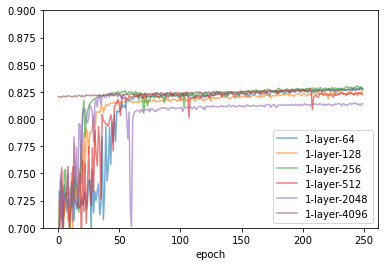

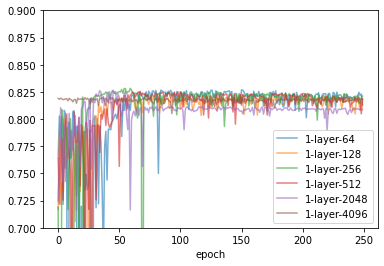

In [15]:
plot_accuracies(hist1_2, lower_ylim=.7, upper_ylim=.9)

## Results from simple dense net

The simple dense net reaches a accuracy on out test dataset of nearly 72 percent. This sounds respectable for such a simple network. A closer look on our confusion matrix reveals that our network suffers from our imbalanced data and is not able to counter the imbalance and thus classifies nearly all patches as non-cancer.


At this point it is difficult to assess what exactly has to be improved, but we suspect the following issues persist:

1. The Neural Network does not learn enough from the features, most likely the size of the network is insufficient to learn the features. When increasing the number of layers and the size of the layers we will encounter additional challenges:
    - We could be overfitting our data, which we can mitigate by using dropbout layer
    - We could have a vanishing gradient, which can be mitigated by using normalisazion betweek the hidden layers 
2. The network minimizes the loss, since the data is imbalanced it will inherently favor negative classifications. To counter this multiple options are available
    - We could downsample the negative patches or upsample the positive patches , where the latter is preferred since no data is ignored this way.
    - We could apply balanced weights to increase the impact to the loss function for the positive patches. This should result in an equivalent result than the upsampling.

We will takle the two above mentioned issues after each other. Fist we try to increase the model size and tune the hyperparameters to fit the data better and learn the complexity of the input. Second we will apply class weights to tackle specifically the imbalanced data

In [16]:
# lower the number of epochs
epochs = 500

histories = []

name="1-layer-128-norm-dropout"
print(name)
model07 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model07.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model07.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))

name="1-layer-4096-norm-dropout"
print(name)
model08 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model08.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model08.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))


name="2-layer-128-256"
print(name)
model09 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model09.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model09.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))

name="3-layer-256-512-256"
print(name)
model10 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model10.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model10.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))

name="3-layer-512-256-128-norm"
print(name)
model11 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model11.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model11.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))

name="3-layer-512-256-128-dropout"
print(name)
model12 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model12.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model12.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))

name="3-layer-512-256-128-norm-dropout"
print(name)
model13 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model13.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model13.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[es]))
hist2 = histories

1-layer-128-norm-dropout
Epoch 1/500
152/152 - 1s - loss: 0.8620 - accuracy: 0.7699 - val_loss: 1.7027 - val_accuracy: 0.7506
Epoch 2/500
152/152 - 1s - loss: 0.4092 - accuracy: 0.8257 - val_loss: 0.4514 - val_accuracy: 0.8254
Epoch 3/500
152/152 - 1s - loss: 0.3779 - accuracy: 0.8411 - val_loss: 0.3751 - val_accuracy: 0.8466
Epoch 4/500
152/152 - 1s - loss: 0.3672 - accuracy: 0.8471 - val_loss: 0.3594 - val_accuracy: 0.8494
Epoch 5/500
152/152 - 1s - loss: 0.3555 - accuracy: 0.8523 - val_loss: 0.3584 - val_accuracy: 0.8501
Epoch 6/500
152/152 - 1s - loss: 0.3477 - accuracy: 0.8560 - val_loss: 0.3534 - val_accuracy: 0.8522
Epoch 7/500
152/152 - 1s - loss: 0.3412 - accuracy: 0.8582 - val_loss: 0.3657 - val_accuracy: 0.8520
Epoch 8/500
152/152 - 1s - loss: 0.3370 - accuracy: 0.8610 - val_loss: 0.3558 - val_accuracy: 0.8512
Epoch 9/500
152/152 - 1s - loss: 0.3308 - accuracy: 0.8634 - val_loss: 0.3562 - val_accuracy: 0.8524
Epoch 10/500
152/152 - 1s - loss: 0.3264 - accuracy: 0.8659 - val_

Epoch 39/500
152/152 - 5s - loss: 0.1623 - accuracy: 0.9428 - val_loss: 0.5463 - val_accuracy: 0.8186
Epoch 40/500
152/152 - 5s - loss: 0.1545 - accuracy: 0.9465 - val_loss: 0.5960 - val_accuracy: 0.8338
Epoch 41/500
152/152 - 5s - loss: 0.1573 - accuracy: 0.9450 - val_loss: 0.5479 - val_accuracy: 0.8370
Epoch 42/500
152/152 - 5s - loss: 0.1468 - accuracy: 0.9489 - val_loss: 0.6282 - val_accuracy: 0.8392
Epoch 43/500
152/152 - 5s - loss: 0.1399 - accuracy: 0.9519 - val_loss: 0.6187 - val_accuracy: 0.8443
Epoch 44/500
152/152 - 5s - loss: 0.1375 - accuracy: 0.9526 - val_loss: 0.6464 - val_accuracy: 0.8305
Epoch 45/500
152/152 - 5s - loss: 0.1404 - accuracy: 0.9523 - val_loss: 0.7002 - val_accuracy: 0.8421
Epoch 46/500
152/152 - 5s - loss: 0.1473 - accuracy: 0.9515 - val_loss: 0.6108 - val_accuracy: 0.8388
Epoch 47/500
152/152 - 5s - loss: 0.1295 - accuracy: 0.9553 - val_loss: 0.7069 - val_accuracy: 0.8379
Epoch 48/500
152/152 - 5s - loss: 0.1326 - accuracy: 0.9549 - val_loss: 0.7077 - v

Epoch 13/500
152/152 - 1s - loss: 0.4176 - accuracy: 0.8128 - val_loss: 0.4107 - val_accuracy: 0.8167
Epoch 14/500
152/152 - 1s - loss: 0.4253 - accuracy: 0.8085 - val_loss: 0.4138 - val_accuracy: 0.8093
Epoch 15/500
152/152 - 1s - loss: 0.4125 - accuracy: 0.8159 - val_loss: 0.4075 - val_accuracy: 0.8166
Epoch 16/500
152/152 - 1s - loss: 0.4132 - accuracy: 0.8154 - val_loss: 0.4169 - val_accuracy: 0.8198
Epoch 17/500
152/152 - 1s - loss: 0.4082 - accuracy: 0.8191 - val_loss: 0.4082 - val_accuracy: 0.8165
Epoch 18/500
152/152 - 1s - loss: 0.4146 - accuracy: 0.8155 - val_loss: 0.4335 - val_accuracy: 0.7948
Epoch 19/500
152/152 - 1s - loss: 0.4089 - accuracy: 0.8186 - val_loss: 0.3983 - val_accuracy: 0.8239
Epoch 20/500
152/152 - 1s - loss: 0.4073 - accuracy: 0.8200 - val_loss: 0.4181 - val_accuracy: 0.8132
Epoch 21/500
152/152 - 1s - loss: 0.4096 - accuracy: 0.8185 - val_loss: 0.3965 - val_accuracy: 0.8239
Epoch 22/500
152/152 - 1s - loss: 0.4083 - accuracy: 0.8188 - val_loss: 0.4159 - v

Epoch 8/500
152/152 - 1s - loss: 0.3512 - accuracy: 0.8512 - val_loss: 0.4323 - val_accuracy: 0.8303
Epoch 9/500
152/152 - 1s - loss: 0.3464 - accuracy: 0.8538 - val_loss: 0.4322 - val_accuracy: 0.7917
Epoch 10/500
152/152 - 1s - loss: 0.3444 - accuracy: 0.8558 - val_loss: 0.5428 - val_accuracy: 0.7547
Epoch 11/500
152/152 - 1s - loss: 0.3410 - accuracy: 0.8556 - val_loss: 0.4895 - val_accuracy: 0.7561
Epoch 12/500
152/152 - 1s - loss: 0.3387 - accuracy: 0.8575 - val_loss: 0.6249 - val_accuracy: 0.7554
Epoch 13/500
152/152 - 1s - loss: 0.3366 - accuracy: 0.8594 - val_loss: 0.5129 - val_accuracy: 0.7584
Epoch 14/500
152/152 - 1s - loss: 0.3326 - accuracy: 0.8614 - val_loss: 0.5928 - val_accuracy: 0.7692
Epoch 15/500
152/152 - 1s - loss: 0.3314 - accuracy: 0.8623 - val_loss: 0.5269 - val_accuracy: 0.7905
Epoch 16/500
152/152 - 1s - loss: 0.3280 - accuracy: 0.8637 - val_loss: 0.7026 - val_accuracy: 0.7669
Epoch 17/500
152/152 - 1s - loss: 0.3261 - accuracy: 0.8652 - val_loss: 0.8888 - val

In [17]:
acc_df(histories)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128-norm-dropout,0.32,87.07%,0.36,85.29%
1-layer-4096-norm-dropout,0.27,89.58%,0.39,85.40%
2-layer-128-256,0.42,81.29%,0.42,81.51%
3-layer-256-512-256,0.41,81.85%,0.40,82.39%
3-layer-512-256-128-norm,0.33,85.64%,0.49,79.20%
3-layer-512-256-128-dropout,0.35,85.12%,0.43,83.03%
3-layer-512-256-128-norm-dropout,0.37,84.18%,0.50,82.94%


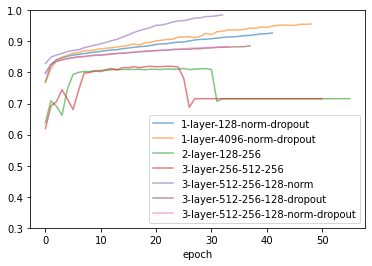

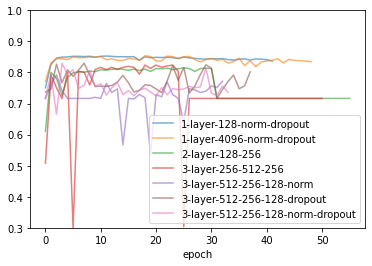

In [33]:
plot_accuracies(hist2, lower_ylim=.3, upper_ylim=1)

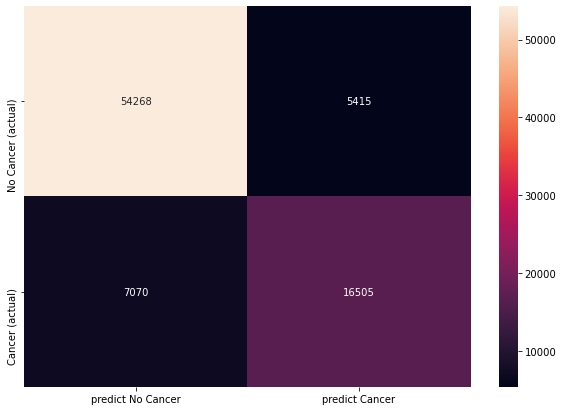

In [19]:
# plot confuction matrix
plt=conf_matrix(model08, x_test, y_test)
plt.show()

## Learnings
- In the above chart we first of all see that just increasing the number of layers and the number of hidden nodes per layer did not improve the performance. On the contrary we can recognize that in the 3rd network the loss is increasing significantly and and the fourth and fifth layer the loss cannot be displayed. This evidence suggests an exploding/vanishing gradient.
- None of the models are able to reach higher performance for our imbalanced dataset and account for the cancer positive cells
With the different model sizes, learning rates, normalization and dropout layers most issues should have be tackled, so lets run tha above models again with balanced weights, that account for the relative number of positive/negative patches

In [20]:
# lower the number of epochs
epochs = 150

total = numpy.asarray(y_data).shape[0]
pos = sum(numpy.asarray(y_data))
neg = total - pos

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / neg) * (total / 2.0)
# weight_for_1 = (1 / pos) * (total / 2.0)

weight_for_0 = (1 / neg) * total
weight_for_1 = (1 / pos) * total

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.40
Weight for class 1: 3.52


In [21]:
# lower the number of epochs
epochs = 500

histories = []

name="1-layer-128-norm-dropout"
print(name)
model14 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model14.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model14.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[lrr, es],
                            class_weight=class_weight))


name="2-layer-128-256-norm-dropout"
print(name)
model15 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model15.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model15.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[lrr, es],
                            class_weight=class_weight))

name="3-layer-512-256-128-norm-dropout"
print(name)
model16 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model16.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model16.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, callbacks=[lrr, es],
                            class_weight=class_weight))
hist3 = histories

1-layer-128-norm-dropout
Epoch 1/500
152/152 - 1s - loss: 4.1757 - accuracy: 0.7607 - val_loss: 1.5602 - val_accuracy: 0.7648
Epoch 2/500
152/152 - 1s - loss: 0.9047 - accuracy: 0.7916 - val_loss: 0.4273 - val_accuracy: 0.8326
Epoch 3/500
152/152 - 1s - loss: 0.8776 - accuracy: 0.7977 - val_loss: 0.4223 - val_accuracy: 0.8063
Epoch 4/500
152/152 - 1s - loss: 0.8598 - accuracy: 0.8022 - val_loss: 0.4096 - val_accuracy: 0.8092
Epoch 5/500
152/152 - 1s - loss: 0.8444 - accuracy: 0.8064 - val_loss: 0.3826 - val_accuracy: 0.8307
Epoch 6/500
152/152 - 1s - loss: 0.8379 - accuracy: 0.8047 - val_loss: 0.3853 - val_accuracy: 0.8267
Epoch 7/500
152/152 - 1s - loss: 0.8293 - accuracy: 0.8066 - val_loss: 0.4253 - val_accuracy: 0.7978
Epoch 8/500
152/152 - 1s - loss: 0.8213 - accuracy: 0.8088 - val_loss: 0.4338 - val_accuracy: 0.7971
Epoch 9/500
152/152 - 1s - loss: 0.8097 - accuracy: 0.8116 - val_loss: 0.4199 - val_accuracy: 0.8015
Epoch 10/500
152/152 - 1s - loss: 0.8110 - accuracy: 0.8104 - val_

Epoch 14/500
152/152 - 1s - loss: 0.7758 - accuracy: 0.8335 - val_loss: 0.4466 - val_accuracy: 0.8169
Epoch 15/500
152/152 - 1s - loss: 0.7682 - accuracy: 0.8345 - val_loss: 0.6460 - val_accuracy: 0.7879
Epoch 16/500
152/152 - 1s - loss: 0.7627 - accuracy: 0.8363 - val_loss: 0.5061 - val_accuracy: 0.7944
Epoch 17/500
152/152 - 1s - loss: 0.7586 - accuracy: 0.8370 - val_loss: 0.5033 - val_accuracy: 0.8011
Epoch 18/500
152/152 - 1s - loss: 0.7543 - accuracy: 0.8387 - val_loss: 0.4084 - val_accuracy: 0.8250
Epoch 19/500
152/152 - 1s - loss: 0.7492 - accuracy: 0.8399 - val_loss: 0.7604 - val_accuracy: 0.7617
Epoch 20/500
152/152 - 1s - loss: 0.7453 - accuracy: 0.8404 - val_loss: 0.4136 - val_accuracy: 0.8226
Epoch 21/500
152/152 - 1s - loss: 0.7368 - accuracy: 0.8429 - val_loss: 0.4603 - val_accuracy: 0.7977
Epoch 22/500
152/152 - 1s - loss: 0.7390 - accuracy: 0.8420 - val_loss: 1.5672 - val_accuracy: 0.7515
Epoch 23/500
152/152 - 1s - loss: 0.7321 - accuracy: 0.8436 - val_loss: 0.5389 - v

In [22]:
acc_df(histories)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128-norm-dropout,0.90,79.16%,0.43,83.26%
2-layer-128-256-norm-dropout,0.86,81.00%,0.37,84.09%
3-layer-512-256-128-norm-dropout,0.72,84.61%,0.42,83.01%


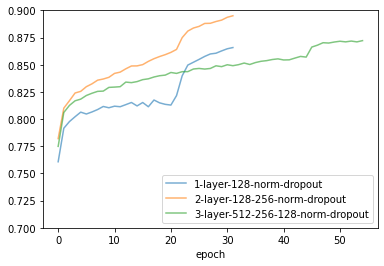

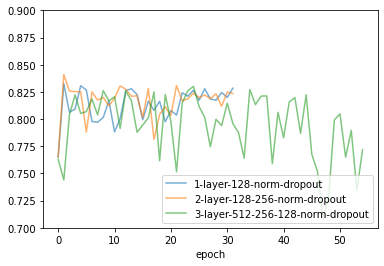

In [35]:
plot_accuracies(hist3, lower_ylim=.7, upper_ylim=.9)

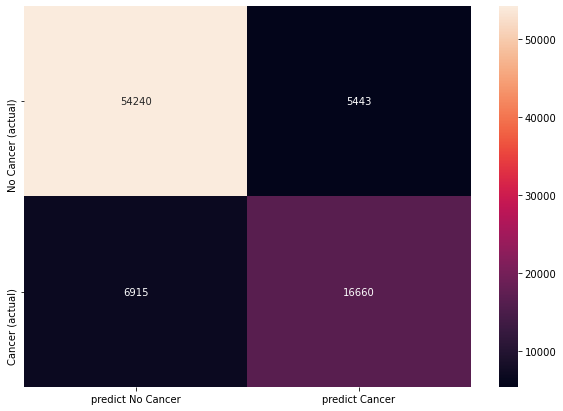

In [42]:
# plot confuction matrix
plt=conf_matrix(model15, x_test, y_test)
plt.show()

## Learnings
- The confusion matrix starts to look better, malicious cells are now classified much less as non-malicious than before
- In the graph above we see that the validation accuracy and loss is decreasing/increasing towards the end
- Train accuracy is now much closer to the validation accuracy (at least for the best epoch) over time they still diverge

Since the training and validatio accuracy are close we can reduce the dropout rate, but at the same time we will add an imageDataGenerator to hopefully increase generalizability of our model.On top we define a learning rate schedule that reduces when a plateau is reached and change all optimizations to from stochastig gradient descent to the adam optimizer.

Since the smaller networks needed more epochs to show improvements we remove the early stopping criterion for those and increase the patience for the rest, to make sure not to stop too early

In [25]:
#Image Data Augmentation

train_generator = ImageDataGenerator(rotation_range=20, horizontal_flip=True, vertical_flip=True)

test_generator = ImageDataGenerator(rotation_range=20, horizontal_flip=True, vertical_flip=True)

val_generator = ImageDataGenerator(rotation_range=20, horizontal_flip=True, vertical_flip=True)

train_generator.fit(x_train)
test_generator.fit(x_test)
val_generator.fit(x_val)

In [26]:
# lower the batch size
batch_size = 512

histories = []

name="1-layer-128-norm-dropout"
print(name)
model17 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model17.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model17.fit(train_generator.flow(x_train, y_train, batch_size=32),
                             batch_size=batch_size, epochs=epochs,
                             validation_data=val_generator.flow(x_val,y_val, batch_size=32),
                             verbose=1, callbacks=[lrr, es],
                             class_weight=class_weight))


name="2-layer-128-256-norm-dropout"
print(name)
model18 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model18.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model18.fit(train_generator.flow(x_train, y_train, batch_size=32),
                             batch_size=batch_size, epochs=epochs,
                             validation_data=val_generator.flow(x_val,y_val, batch_size=32),
                             verbose=1, callbacks=[lrr, es],
                             class_weight=class_weight))

name="3-layer-512-256-128-norm-dropout"
print(name)
model19 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model19.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

histories.append(model19.fit(train_generator.flow(x_train, y_train, batch_size=32),
                             batch_size=batch_size, epochs=epochs,
                             validation_data=val_generator.flow(x_val,y_val, batch_size=32),
                             verbose=1, callbacks=[lrr, es],
                             class_weight=class_weight))
hist4 = histories

1-layer-128-norm-dropout
Epoch 1/500
4857/4857 [==============================] - 93s 19ms/step - loss: 1.6078 - accuracy: 0.6134 - val_loss: 0.7114 - val_accuracy: 0.2835
Epoch 2/500
4857/4857 [==============================] - 92s 19ms/step - loss: 1.3865 - accuracy: 0.4867 - val_loss: 0.6895 - val_accuracy: 0.7165
Epoch 3/500
4857/4857 [==============================] - 93s 19ms/step - loss: 1.3875 - accuracy: 0.4945 - val_loss: 0.6874 - val_accuracy: 0.7165
Epoch 4/500
4857/4857 [==============================] - 92s 19ms/step - loss: 1.3875 - accuracy: 0.4929 - val_loss: 0.6770 - val_accuracy: 0.7165
Epoch 5/500
4857/4857 [==============================] - 92s 19ms/step - loss: 1.3875 - accuracy: 0.4946 - val_loss: 0.6981 - val_accuracy: 0.2835
Epoch 6/500
4857/4857 [==============================] - 93s 19ms/step - loss: 1.3875 - accuracy: 0.4857 - val_loss: 0.6895 - val_accuracy: 0.7165: 1.3880 -  - ET
Epoch 7/500
4857/4857 [==============================] - 93s 19ms/step - loss

4857/4857 [==============================] - 94s 19ms/step - loss: 0.9396 - accuracy: 0.8185 - val_loss: 0.3956 - val_accuracy: 0.8436
Epoch 22/500
4857/4857 [==============================] - 94s 19ms/step - loss: 0.9383 - accuracy: 0.8183 - val_loss: 0.3779 - val_accuracy: 0.8470
Epoch 23/500
4857/4857 [==============================] - 94s 19ms/step - loss: 0.9475 - accuracy: 0.8175 - val_loss: 0.3828 - val_accuracy: 0.8450
Epoch 24/500
4857/4857 [==============================] - 94s 19ms/step - loss: 0.9367 - accuracy: 0.8184 - val_loss: 0.3855 - val_accuracy: 0.8524
Epoch 25/500
4857/4857 [==============================] - 94s 19ms/step - loss: 0.9318 - accuracy: 0.8193 - val_loss: 0.4101 - val_accuracy: 0.8461
Epoch 26/500
4857/4857 [==============================] - 95s 20ms/step - loss: 0.9384 - accuracy: 0.8193 - val_loss: 0.3745 - val_accuracy: 0.8531
Epoch 27/500
4857/4857 [==============================] - 95s 20ms/step - loss: 0.9333 - accuracy: 0.8197 - val_loss: 0.3937 

4857/4857 [==============================] - 94s 19ms/step - loss: 0.9414 - accuracy: 0.8203 - val_loss: 0.4227 - val_accuracy: 0.8433
Epoch 77/500
4857/4857 [==============================] - 94s 19ms/step - loss: 0.9454 - accuracy: 0.8203 - val_loss: 0.4191 - val_accuracy: 0.8366
Epoch 78/500
4857/4857 [==============================] - 94s 19ms/step - loss: 0.9435 - accuracy: 0.8209 - val_loss: 0.4815 - val_accuracy: 0.8343
Epoch 79/500
4857/4857 [==============================] - 94s 19ms/step - loss: 0.9419 - accuracy: 0.8212 - val_loss: 0.4309 - val_accuracy: 0.8444
Epoch 80/500
4857/4857 [==============================] - 94s 19ms/step - loss: 0.9511 - accuracy: 0.8206 - val_loss: 0.4747 - val_accuracy: 0.8252
Epoch 81/500
4854/4857 [============================>.] - ETA: 0s - loss: 0.9504 - accuracy: 0.8215
Epoch 00081: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
4857/4857 [==============================] - 95s 20ms/step - loss: 0.9506 - accuracy: 0.8214 

4857/4857 [==============================] - 95s 20ms/step - loss: 1.0065 - accuracy: 0.8040 - val_loss: 0.7468 - val_accuracy: 0.6779
Epoch 38/500
4857/4857 [==============================] - 95s 19ms/step - loss: 1.0121 - accuracy: 0.8028 - val_loss: 0.4555 - val_accuracy: 0.8212
Epoch 39/500
4857/4857 [==============================] - 95s 19ms/step - loss: 1.0042 - accuracy: 0.8056 - val_loss: 0.4816 - val_accuracy: 0.7942
Epoch 40/500
4857/4857 [==============================] - 93s 19ms/step - loss: 1.0081 - accuracy: 0.8054 - val_loss: 18.7682 - val_accuracy: 0.8248
Epoch 41/500
4857/4857 [==============================] - 94s 19ms/step - loss: 1.0028 - accuracy: 0.8045 - val_loss: 0.4128 - val_accuracy: 0.8239
Epoch 42/500
4857/4857 [==============================] - 94s 19ms/step - loss: 1.0124 - accuracy: 0.8031 - val_loss: 0.6071 - val_accuracy: 0.8102
Epoch 43/500
4857/4857 [==============================] - 93s 19ms/step - loss: 1.0168 - accuracy: 0.8016 - val_loss: 8.2157

4857/4857 [==============================] - 93s 19ms/step - loss: 0.9543 - accuracy: 0.8100 - val_loss: 0.6772 - val_accuracy: 0.8091
Epoch 92/500
4857/4857 [==============================] - 92s 19ms/step - loss: 0.9526 - accuracy: 0.8103 - val_loss: 0.4867 - val_accuracy: 0.7970
Epoch 93/500
4857/4857 [==============================] - 94s 19ms/step - loss: 0.9480 - accuracy: 0.8098 - val_loss: 0.5070 - val_accuracy: 0.7916
Epoch 94/500
4857/4857 [==============================] - 95s 20ms/step - loss: 0.9513 - accuracy: 0.8100 - val_loss: 0.4698 - val_accuracy: 0.7938
Epoch 95/500
4857/4857 [==============================] - 93s 19ms/step - loss: 0.9477 - accuracy: 0.8100 - val_loss: 0.4666 - val_accuracy: 0.8012
Epoch 96/500
4857/4857 [==============================] - 93s 19ms/step - loss: 0.9406 - accuracy: 0.8100 - val_loss: 0.4921 - val_accuracy: 0.7997
Epoch 97/500
4857/4857 [==============================] - 94s 19ms/step - loss: 0.9465 - accuracy: 0.8079 - val_loss: 0.4873 

In [27]:
acc_df(histories)

,loss,accuracy,val_loss,val_accuracy
model size,,,,
1-layer-128-norm-dropout,1.39,48.67%,0.69,71.65%
2-layer-128-256-norm-dropout,0.94,82.14%,0.39,85.65%
3-layer-512-256-128-norm-dropout,1.01,80.72%,0.41,83.56%


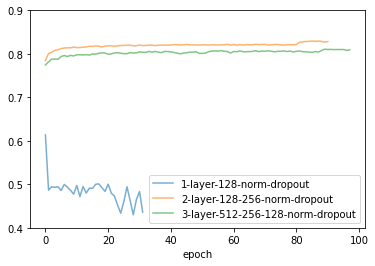

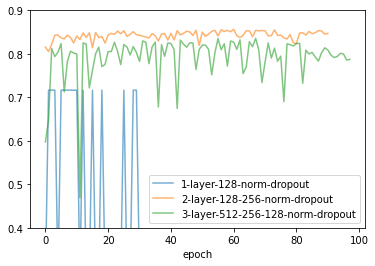

In [44]:
plot_accuracies(hist4, lower_ylim=.4, upper_ylim=.9)

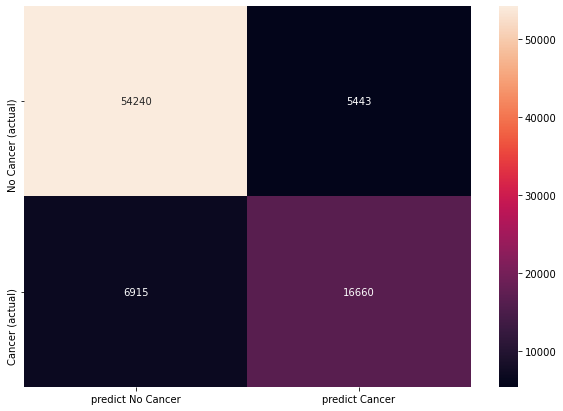

In [45]:
# plot confuction matrix
plt=conf_matrix(model17, x_test, y_test)
plt.show()

# Results

The final model does not seem to be far superior to previous ones if we observe the accuracy and the loss. It has one of the best performances if we measure validation loss and accuracy, but the first model with the learning rate 0.01 reached a similar performance according to those measures.
Since we are building a model for medical diagnosis, accuracy and loss are not neccessarily the most important measures (even though it makes sense to optimize them). including the confusion matrix in our model evaluation shows that we are constantly improving on predicting malicious cells and also minimize the classification of malicious cells as harmless, a missclassification, which could have severe implications for the patient.

Increasing the size of the model to a certain size, adding dropout and normalization layers, countering the imbalance of the data with balanced weights as well as applying a learning rate schedule improved the result significantly.

